<a id='Top'></a>
# 24. Internet APIs
<div class="alert alert-block alert-danger" style="margin-top: 10px">
<font color=black>

- 24.1. [Requesting data from the Internet](#24.1)
- 24.2. [The Internet: Behind the Scenes](#24.2)
- 24.3. [Anatomy of URLs](#24.3)
- 24.4. [The HTTP protocol](#24.4)
- 24.5. [Using REST APIs](#24.5)
  - 24.5.1. [URL Structure for REST APIs](#24.5.1)
  - 24.5.2. [Encoding URL Parameters](#24.5.2)
- 24.6. [Fetching a page](#24.6)
  - 24.6.1. [Fetching in python with requests.get](#24.6.1)
  - 24.6.2. [More Details of Response objects](#24.6.2)
  - 24.6.3. [Using requests.get to encode URL parameters](#24.6.3)
- 24.7. [Caching Response Content](#24.7)
  - 24.7.1. [The <font color=red>requests_with_caching</font> module](#24.7.1)
  - 24.7.2. [Implementation of the <font color=red>requests_with_caching</font> module](#24.7.2)
- 24.8. [Figuring Out How to Use a REST API](#24.8)
  - 24.8.1. [Example: the datamuse API](#24.8.1)
  - 24.8.2. [Defining a function to make repeated invocations](#24.8.2)
- 24.9. [Debugging calls to requests.get()](#24.9)
  - 24.9.1. [In the Runestone environment](#24.9.1)
  - 24.9.2. [In a full python environment](#24.9.2)
- 24.10. [Requests Cookbook](#24.10)
- 24.11. [Searching for Media on iTunes](#24.11)
- 24.12. [Searching for tags on flickr](#24.12)
- 24.13. [Unicode for non-English characters](#24.13)
- 24.14. [Project - OMDB and TasteDive](#24.14)</div>

<a id='24.1'></a>
## 24.1. Requesting data from the Internet
There’s an amazing variety of data out there on the Internet. We are all familiar with using a web browser to access it. We can also write computer programs that access data. Rather just showing it directly to people, computer programs can process the data in useful ways. They can also act on a much larger scale, processing more data from more sources.

In this chapter, you will learn how to use the python requests module to request data in python programs. We will also take a look behind the scenes to give you a better sense of what’s really going on when you request data over the Internet, either with a browser or from a Python program.
 
<a id='24.2'></a>
## 24.2. The Internet: Behind the Scenes
[Back to top](#Top)
    
The Internet is a transport mechanism that lets any connected device communicate with any other connected device. Behind the scenes:

- Each device has a globally distinct IP address, which is a 32 bit number. Usually an IP address is represented as a sequence of four decimal numbers, each number in the range (0, 255). For example, when I checked the IP address for my laptop just now, it was 141.211.203.248. Any IP address beginning with 141.211 is for a device at the University of Michigan. When I take my laptop home and connect to a network there, my laptop gets a different IP address that it uses there.

- Data is chopped up into reasonable sized packets (up to 65,535 bytes, but usually much smaller).

- Each data packet has a header that includes the destination IP address.

- Each packet is routed independently, getting passed on from one computing device to another until it reaches its destination. The computing devices that do that packet forwarding are called routers. Each router keeps an address table that says, when it gets a packet for some destination address, which of its neighbors should it pass the packet on to. The routers are constantly talking to each other passing information about how they should update their routing tables. The system was designed to be resistant to any local damage. If some of the routers stop working, the rest of the routers talk to each other and start routing packets around in a different way so that packets still reach their intended destination if there is some path to get there. It is this technical capability that has spawned metaphoric quotes like this one from John Gilmore: “The Net interprets censorship as damage and routes around it.”

- At the destination, the packets are reassembled into the original data message

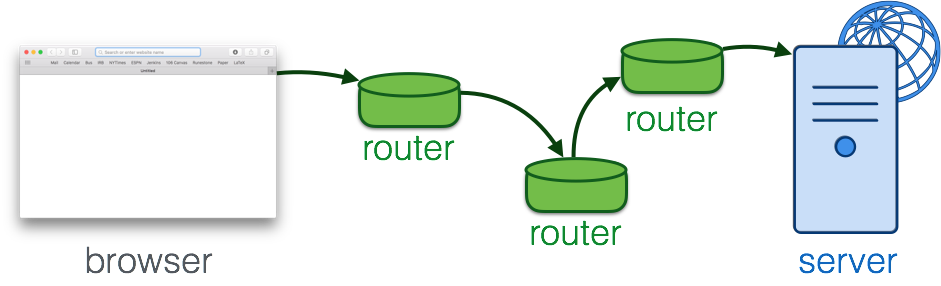

<a id='24.3'></a>
## 24.3. Anatomy of URLs
[Back to top](#Top)

A URL is used by a browser or other program to specify what server to connect to and what page to ask for. Like other things that will be interpreted by computer programs, URLs have a very specific formal structure. If you put a colon in the wrong place, the URL won’t work correctly. The overall structure of a URL is:   

In [ ]:
<scheme>://<host>:<port>/<path>

Usually, the _scheme_ will be http or https. The s in https stands for “secure”. When you use https, all of the communication between the two devices is encrypted. Any devices that intercepts some of the packets along the way will be unable to decrypt the contents and figure out what the data was.

Other schemes that you will sometimes see include ftp (for file transfer) and mailto (for email addresses).

The _host_ will usually be a domain name, like si.umich.edu or github.com or google.com. When the URL specifies a domain name, the first thing the computer program does is look up the domain name to find the 32-bit IP address. For example, right now the IP adddress for github.com is 192.30.252.130. This could change if, for example, github moved its servers to a different location or contracted with a different Internet provider. Lookups use something called the Domain Name System, or DNS for short. Changes to the mapping from domain names to IP addresses can take a little while to propagate: if github.com announces a new IP address associated with its domain, it might take up to 24 hours for some computers to start translating github.com to the new IP address.

Alternatively, the host can be an IP address directly. This is less common, because IP addresses are harder to remember and because a URL containing a domain name will continue to work even if the remote server keeps its domain name but moves to a different IP address.

The _:port_ is optional. If it is omitted, the default port number is 80. The port number is used on the receiving end to decide which computer program should get the data that has been received. We probably will not encounter any URLs that include the : and a port number in this course.

The _/path_ is also optional. It specifies something about which page, or more generally which contents, are being requested.

For example, consider the url https://github.com/presnick/runestone:

- <font color=blue>https://</font> says to use the secure http protocol

- github.com says to connect to the server at github.com, which currently maps to the IP address 192.30.252.130. The connection will be made on the default port, which is 443 for https.

- /presnick/runestone says to ask the remote server for the page presnick/runestone. It is up to the remote server to decide how to map that to the contents of a file it has access to, or to some content that it generates on the fly.

The url http://blueserver.com/path?k=val is another example that we can consider. The path here a bit different from https://github.com/presnick/runestone because it includes what are called “query parameters”, the information after the ?.



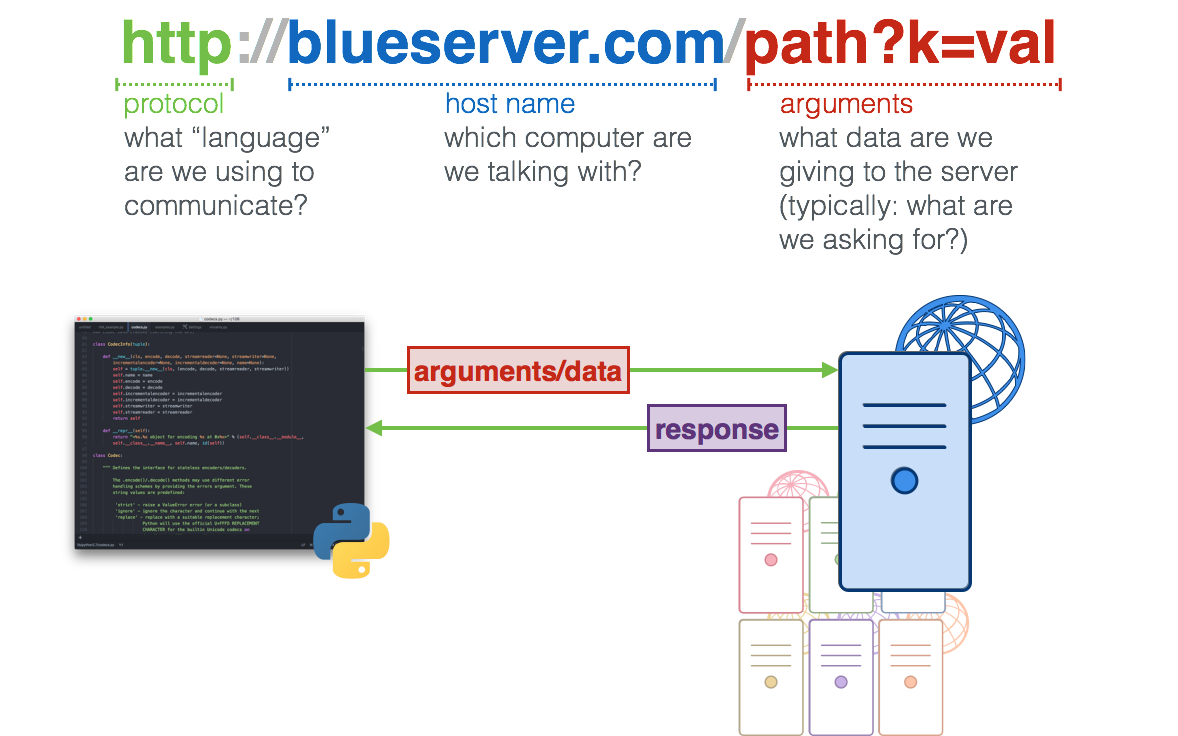

<a id='24.4'></a>
## 24.4. The HTTP protocol
[Back to top](#Top)

A protocol specifies the order in which parties will speak and the format of what they say and the content of appropriate responses.

HTTP is the protocol that specifies how web browsers or other programs communicate with web servers. One version of the formal specification, before it was later split into multiple documents, was IETF RFC 2616. It is 176 pages long! Fortunately, the basics are pretty easy to understand.

- __Step 1: the client makes a request to the server.__
 - If the request only involves fetching data, the client sends a message of the form GET <path>, where <path> is the path part of the URL
 - If the request involves sending some data (e.g., a file upload, or some authentication information), the message starts with POST
 - __In either case, the client sends some HTTP headers. These include:__
   - The type of client program. This allows the server to send back different things to small mobile devices than desktop browsers (a “responsive” website)
   - Any cookies that the server previously asked the client to hold onto. This allows the server to continue previous interactions, rather than treating every request as stand-alone. It also allows ad networks to place personalized ads.
 - After the HTTP headers, for a POST type communication, there is some data (the body of the request).

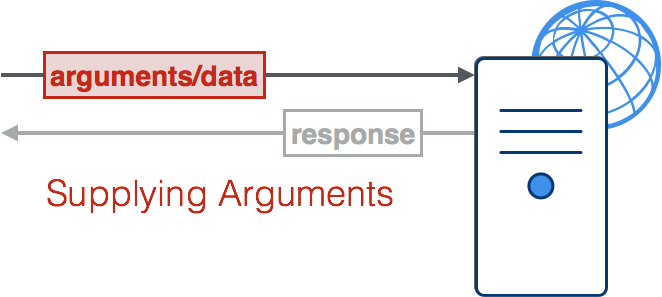

- __Step 2: the server responds to the client.__
 - __The server first sends back some HTTP headers. These include:__
   - a response code indicating whether the server thinks it has fulfilled the request or not.
   - a description of the type of content it is sending back (e.g., text/html when it is sending html-formatted text).
   - any cookies it would like the client to hold onto and send back the next time it communicates with the server.

 - After the headers come the contents. This is the stuff that you would see if you ask to “View Source” in a browser.

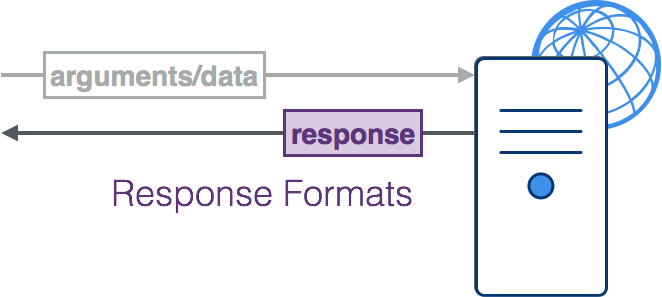

<a id='24.5'></a>
## 24.5. Using REST APIs
[Back to top](#Top)

REST stands for REpresentational State Transfer. It originally had a more abstract meaning, but has come to be a shorthand name for web sites that act a bit like python functions, taking as inputs values for certain parameters and producing outputs in the form of a long text string.

API stands for Application Programming Interface. An API specifies how an external program (an application program) can request that a program perform certain computations.

Putting the two together, a REST API specifies how external programs can make HTTP requests to a web site in order to request that some computation be carried out and data returned as output. When a website is designed to accept requests generated by other computer programs, and produce outputs to be consumed by other programs, it is sometimes called a web service, as opposed to a web site which produces output meant for humans to consume in a web browser.

Of course, a web browser is just a computer program, so all requests to web sites come from other computer programs. But usually a browser requests data from a web site in order to display it directly to a human user of the browser.

Prior to the development of REST APIs, there were other ways that computer programs made remote requests to other computers on a network, asking them to perform some computation or retrieve some data. Those other techniques are still in use. REST APIs are particularly convenient, however, both for students and for others, because it is easy to see what is going on in a request and a response between two computers, and thus it is easier to debug.

We will examine a common pattern used in REST APIs, where there is a base URL that defines an “endpoint”, and then additional information is appended to the URL as query parameters, and the response comes back not as HTML but as a format called JSON. Along the way, we will see some functions in python modules that are helpful for constructing the URLS and for processing the JSON formatted response.

<a id='24.5.1'></a>
### 24.5.1. URL Structure for REST APIs
[Back to top](#Top)

In a REST API, the client or application program– the kind of program you will be writing– makes an HTTP request that includes information about what kind of request it is making. Web sites are free to define whatever format they want for how the request should be formatted. This chapter covers a particularly common and particularly simple format, where the request information is encoded right in the URL. This is convenient, because if something goes wrong, we can debug by copying the URL into a browser and see what happens when it tries to visit that URL.

In this format, the URL has a standard structure:

- the base URL
- a <font color=red>?</font> character
- one or more key-value pairs, formatted as <font color=red>key=value</font> pairs and separated by the <font color=red>&</font> character.

For example, consider the URL https://itunes.apple.com/search?term=Ann+Arbor&entity=podcast. Try copying that URL into a browser, or just clicking on it. It retrieves data about podcasts posted from Ann Arbor, MI. Depending on your browser, it may put the contents into a file attachment that you have to open up to see the contents, or it may just show the contents in a browser window.

Let’s pull apart that URL.

- the base URL: https://itunes.apple.com/search
- a <font color=red>?</font> character
- key=value pairs. In this case, there are two pairs. The keys are <font color=red>term</font> and <font color=red>entity</font>. An <font color=red>&</font> separates the two pairs.

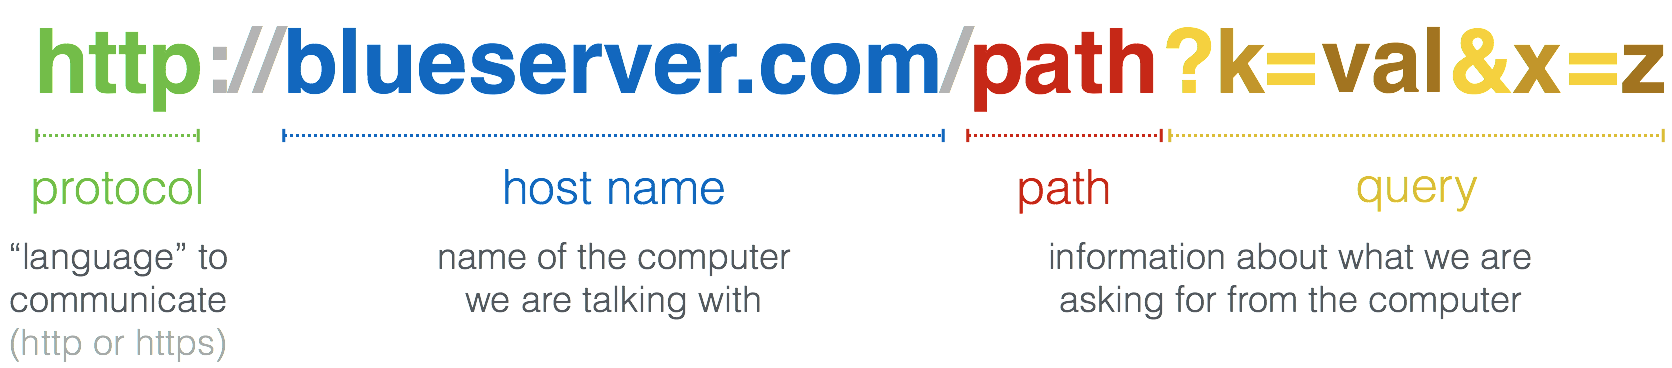

Note that in the search term Ann Arbor, the space had to be “encoded” as +. More on that below.

<a id='24.5.2'></a>
### 24.5.2. Encoding URL Parameters
[Back to top](#Top)

Here’s another URL that has a similar format. https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. It’s a search on Google for images that match the string “violins and guitars”. It’s not actually based on a REST API, because the contents that come back are meant to be displayed in a browser. But the URL has the same structure we have been exploring above and introduces the idea of “encoding” URL parameters.

- The base URL is https://www.google.com/search
- <font color=red>?</font>
- __Two key=value parameters, separated by__ <font color=red>&</font>
  - <font color=red>q=%22violins+and+guitars%22</font> says that the query to search for is “violins and guitars”.
  - <font color=red>tbm=isch</font> says to go to the tab for image search

Now why is <font color=red>"violins and guitars"</font> represented in the URL as <font color=red>%22violins+and+guitars%22</font>? The answer is that some characters are not safe to include, as is, in URLs. For example, a URL path is not allowed to include the double -quote character. It also can’t include a <font color=red>:</font> or <font color=red>/</font> or a space. Whenever we want to include one of those characters in a URL, we have to encode them with other characters. A space is encoded as <font color=red>+</font>. <font color=red>"</font> is encoded as <font color=red>%22</font>. <font color=red>:</font> would be encoded as <font color=red>%3A</font>. And so on.

<a id='24.6'></a>
## 24.6. Fetching a page
[Back to top](#Top)

The web works with a metaphor of “pages”. When you put a URL into a browser, you see a “page” of content.

For example, if you visit https://github.com/RunestoneInteractive/RunestoneServer, you will see the home page for the open source project whose contents are used to run this online textbook.

The browser is just a computer program that fetches the contents and displays them in a nice way. If you want to see what the contents are, in plain text, right click your mouse on the page and select View source, or whatever the equivalent is in your browser.

<a id='24.6.1'></a>
### 24.6.1. Fetching in python with requests.get
[Back to top](#Top)

You don’t need to use a browser to fetch the contents of a page, though. In Python, there’s a module available, called requests. You can use the get function in the requests module to fetch the contents of a page.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
For illustration purposes, try visiting https://api.datamuse.com/words?rel_rhy=funny in your browser. It returns data in JSON format, not in HTML. Your browser will display the results, information about some words that rhyme with “funny”, but it won’t look like a normal web page. Then try running the code below to fetch the same text string in a python program. Try changing “funny” to some other word, both in the browser, and in the code below. You’ll see that, either way, you are retrieving the same thing, the datamuse API’s response to your request for words that rhyme with some word that you are sending as a query parameter.

In [ ]:
import requests
import json

page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
print(type(page))
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched
print("------")
x = page.json() # turn page.text into a python object
print(type(x))
print("---first item in the list---")
print(x[0])
print("---the whole list, pretty printed---")
print(json.dumps(x, indent=2)) # pretty print the results

<a id='24.6.2'></a>
### 24.6.2. More Details of Response objects
[Back to top](#Top)

Once we run <font color=red>requests.get</font>, a python object is returned. It’s an instance of a class called Response that is defined in the requests module. We won’t look at it’s definition. Think of it as analogous to the Turtle class. Each instance of the class has some attributes; different instances have different values for the same attribute. All instances can also invoke certain methods that are defined for the class.

In the Runestone environment, we have a very limited version of the <font color=red>requests</font> module available. The Response object has only two attributes that are set, and one method that can be invoked.

- The .text attribute. It contains the contents of the file or other information available from the url (or sometimes an error message).
- The .url attribute. We will see later that <font color=red>requests.get</font> takes an optional second parameter that is used to add some characters to the end of the base url that is the first parameter. The .url attribute displays the full url that was generated from the input parameters. It can be helpful for debugging purposes; you can print out the URL, paste it into a browser, and see exactly what was returned.
- The .json() method. This converts the text into a python list or dictionary, by passing the contents of the .text attribute to the <font color=red>jsons.loads</font> function.

The full Requests module provides some additional attributes in the Response object. These are not implemented in the Runestone environment.

- The .status_code attribute.
 - When a server thinks that it is sending back what was requested, it sends the code 200.
 - When the requested page doesn’t exist, it sends back code 404, which is sometimes described as “File Not Found”.
 - When the page has moved to a different location, it sends back code 301 and a different URL where the client is supposed to retrieve from. In the full implementation of the <font color=red>requests</font> module, the <font color=red>get</font> function is so smart that when it gets a 301, it looks at the new url and fetches it. For example, github redirects all requests using http to the corresponding page using https (the secure http protocol). Thus, when we ask for http://github.com/presnick/runestone, github sends back a 301 code and the url https://github.com/presnick/runestone. The requests.get function then fetches the other url. It reports a status of 200 and the updated url. We have to do further inquire to find out that a redirection occurred (see below).

- The .headers attribute has as its value a dictionary consisting of keys and values. To find out all the headers, you can run the code and add a statement <font color=red>print(p.headers.keys())</font>. One of the headers is ‘Content-type’. Some possible values are <font color=red>text/html; charset-utf-8</font> and <font color=red>application/json; charset=utf-8</font>.
- The .history attribute contains a list of previous responses, if there were redirects.

To summarize, a Response object, in the full implementation of the <font color=red>requests</font> module has the following useful attributes that can be accessed in your program:

- .text
- .url
- .json()
- .status_code (not available in Runestone implementation)
- .headers (not available in Runestone implementation)
- .history (not available in Runestone implementation)

<a id='24.6.3'></a>
### 24.6.3. Using requests.get to encode URL parameters
[Back to top](#Top)

Fortunately, when you want to pass information as a URL parameter value, you don’t have to remember all the substitutions that are required to encode special characters. Instead, that capability is built into the requests module.

The <font color=red>get</font> function in the requests module takes an optional parameter called <font color=red>params</font>. If a value is specified for that parameter, it should be a dictionary. The keys and values in that dictionary are used to append something to the URL that is requested from the remote site.

For example, in the following, the base url is https://google.com/search. A dictionary with two parameters is passed. Thus, the whole url is that base url, plus a question mark, “?”, plus a “q=…” and a “tbm=…” separated by an “&”. In other words, the final url that is visited is https://www.google.com/search?q=%22violins+and+guitars%22&tbm=isch. Actually, because dictionary keys are unordered in python, the final url might sometimes have the encoded key-value pairs in the other order: https://www.google.com/search?tbm=isch&q=%22violins+and+guitars%22. Fortunately, most websites that accept URL parameters in this form will accept the key-value pairs in any order.

In [ ]:
d = {'q': '"violins and guitars"', 'tbm': 'isch'}
results = requests.get("https://google.com/search", params=d)
print(results.url)

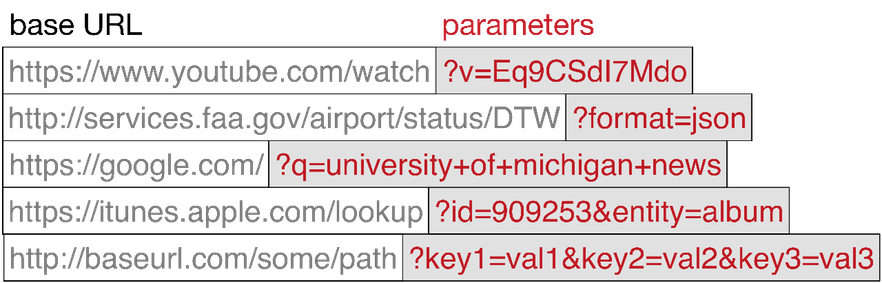

Here’s an executable sample, using the optional params parameter of <font color=red>requests.get</font>. It gets the same data from the datamus api that we saw previously. Here, however, the full url is built inside the call to <font color=red>requests.get</font>; we can see what url was built by printing it out, on line 5.

In [ ]:
import requests

# page = requests.get("https://api.datamuse.com/words?rel_rhy=funny")
kval_pairs = {'rel_rhy': 'funny'}
page = requests.get("https://api.datamuse.com/words", params=kval_pairs)
print(page.text[:150]) # print the first 150 characters
print(page.url) # print the url that was fetched

### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. How would you request the URL http://bar.com/goodstuff?greet=hi+there&frosted=no using the requests module?
    
  A. requests.get("http://bar.com/goodstuff", '?", {'greet': 'hi there'}, '&', {'frosted':'no'})  
  B. requests.get("http://bar.com/", params = {'goodstuff':'?', 'greet':'hi there', 'frosted':'no'})  
  C. requests.get("http://bar.com/goodstuff", params = ['greet', 'hi', 'there', 'frosted', 'no'])  
  D. requests.get("http://bar.com/goodstuff", params = {'greet': 'hi there', 'frosted':'no'})

<details><summary>Click here for the solution</summary>

<font color=red>► </font>D. requests.get("http://bar.com/goodstuff", params = {'greet': 'hi there', 'frosted':'no'})  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ The ? and & are added automatically, and the space in hi there is automatically encoded as %3A.

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
2. If <font color=red>resp</font> is a Response object returned by a call to <font color=red>requests.get()</font>, which of the following is a way to extract the contents into a python dictionary or list?

  A. resp.json()  
  B. resp.json  
  C. json.dumps(resp.text)  
  D. json.loads(resp.text)  
  E. json.loads(resp.url)

<details><summary>Click here for the solution</summary>

<font color=red>► </font>A. resp.json()    
<font color=red>► </font>D. json.loads(resp.text)  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Correct.<br>
  A. json() invokes the json method<br>
  D. loads turns a json-formatted string into a list or dictionary

</details>

<a id='24.7'></a>
## 24.7. Caching Response Content
[Back to top](#Top)

You haven’t experienced it yet, but if you get complicated data back from a REST API, it may take you many tries to compose and debug code that processes that data in the way that you want. (See the <font color=blue>Nested Data chapter</font>.) It is a good practice, for many reasons, not to keep contacting a REST API to re-request the same data every time you run your program.

To avoid re-requesting the same data, we will use a programming pattern known as __caching__. It works like this:

1. Before doing some expensive operation (like calling <font color=red>requests.get</font> to get data from a REST API), check whether you have already saved (“cached”) the results that would be generated by making that request
2. If so, return that same data.
3. If not, perform the expensive operation and save (“cache”) the results (e.g. the complicated data) in your cache so you won’t have to perform it again the next time.

If you go on to learn about web development, you’ll find that you encounter caching all the time – if you’ve ever had the experience of seeing old data when you go to a website and thinking, “Huh, that’s weird, it should really be different now… why am I still seeing that?” that happens because the browser has accessed a cached version of the site.

There are at least four reasons why caching is a good idea during your software development using REST APIs:

- It reduces load on the website that is providing you data. It is always nice to be courteous when using other people’s resources. Moreover, some websites impose rate limits: for example, after 15 requests in a 15 minute period, the site may start sending error responses. That will be confusing and annoying for you.
- It will make your program run faster. Connections over the Internet can take a few seconds, or even tens of seconds, if you are requesting a lot of data. It might not seem like much, but debugging is a lot easier when you can make a change in your program, run it, and get an almost instant response.
- It is harder to debug the code that processes complicated data if the content that is coming back can change on each run of your code. It’s amazing to be able to write programs that fetch real-time data like the available iTunes podcasts or the latest tweets from Twitter. But it can be hard to debug that code if you are having problems that only occur on certain Tweets (e.g. those in foreign languages). When you encounter problematic data, it’s helpful if you save a copy and can debug your program working on that saved, static copy of the data.
- It is easier to run automated tests on code that retrieves data if the data can never change, for the same reasons it is helpful for debugging. In fact, we rely on use of cached data in the automated tests that check your code in exercises.

There are some downsides to caching data – for example, if you always want to find out when data has changed, and your default is to rely on already-cached data, then you have a problem. However, when you’re working on developing code that will work, caching is worth the tradeoff.

<a id='24.7.1'></a>
### 24.7.1. The <font color=red>requests_with_caching</font> module
[Back to top](#Top)

In this book, we are providing a special module, called <font color=red>request_with_caching</font>.

Here’s how you’ll use this module.

- Your code will include a statement to import the module, import <font color=red>requests_with_caching</font>.
- Instead of <font color=red>invoking requests.get()</font>, you’ll invoke <font color=red>requests_with_caching.get()</font>.

You’ll get exactly the same Response object back that you would have gotten. But you’ll also get a printout in the output window with one of the following three diagnostic messages:

- found in permanent cache
- found in page-specific cache
- new; adding to cache

The permanent cache is contained in a file that is built into the textbook. Your program can use its contents but can’t add to it.

The page-specific cache is a new file that is created the first time you make a request for a url that wasn’t in the permanent cache. Each subsequent request for a new url results in more data being written to the page-specific cache. After you run an activecode that adds something to the page-specific cache, you’ll see a little window below it where you can inspect the contents of the page-specific cache. When you reload the webpage, that page-specific cache will be gone; hence the name.

There are a couple of other optional parameters for the function <font color=red>requests_with_caching.get()</font>.

- <font color=red>cache_file</font> – it’s value should be a string specifying the name of the file containing the permanent cache. If you don’t specify anything, the default value is “permanent_cache.txt”. For the datamuse API, we’ve provide a cache in a file called datamuse_cache.txt. It just contains the saved response to the query for “https://api.datamuse.com/words?rel_rhy=funny”.
- <font color=red>private_keys_to_ignore</font> – its value should be a list of strings. These are keys from the parameters dictionary that should be ignored when deciding whether the current request matches a previous request. The main purpose of this is that it allows us to return a result from the cache for some REST APIs that would otherwise require you to provide an API key in order to make a request. By default, it is set to [“api_key”], which is a query parameter used with the flickr API. You should not need to set this optional parameter.

In [ ]:
import requests_with_caching

# it's not found in the permanent cache
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=happy", permanent_cache_file="datamuse_cache.txt")
print(res.text[:100])

# this time it will be found in the temporary cache
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=happy", permanent_cache_file="datamuse_cache.txt")

# This one is in the permanent cache.
res = requests_with_caching.get("https://api.datamuse.com/words?rel_rhy=funny", permanent_cache_file="datamuse_cache.txt")

<a id='24.7.2'></a>
### 24.7.2. Implementation of the <font color=red>requests_with_caching</font> module
[Back to top](#Top)

You may find it useful to understand how this module works. The source code is not very complicated; we’ve reproduced it below. You can use it as a template for implementing code for your own caching pattern in other settings.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
This module is not available outside this textbook; in a full python environment you won’t be able to install a requests_with_caching module. But you can copy the code and make it work outside the textbook environment.</div>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
We have optimized this code for conceptual simplicity, so that it is useful as a teaching tool. It is not very efficient, because it always stores cached contents in a file, rather than saving it in memory. If you are ever implementing the caching pattern just for the duration of a program’s run, you might want to save cached content in a python dictionary in memory rather than writing it to a file.</div>

The basic idea in the code is to maintain the cache as a dictionary with keys representing API requests that have been made, and values representing the text that was retrieved. In order to make our cache live beyond one program execution, we store it in a file. Hence, there are helper functions <font color=red>_write_to_file</font> and <font color=red>read_to_file</font> that write a cache dictionary to and read it from a file.

In order for the textbook to provide a cache file that can’t be overwritten, we distinguish between the permanent file, which is provided as part of the online textbook, and a temporary cache file that will live only until the page is reloaded.

In [ ]:
import requests
import json

PERMANENT_CACHE_FNAME = "permanent_cache.txt"
TEMP_CACHE_FNAME = "this_page_cache.txt"

def _write_to_file(cache, fname):
    with open(fname, 'w') as outfile:
        outfile.write(json.dumps(cache, indent=2))

def _read_from_file(fname):
    try:
        with open(fname, 'r') as infile:
            res = infile.read()
            return json.loads(res)
    except:
        return {}

def add_to_cache(cache_file, cache_key, cache_value):
    temp_cache = _read_from_file(cache_file)
    temp_cache[cache_key] = cache_value
    _write_to_file(temp_cache, cache_file)

def clear_cache(cache_file=TEMP_CACHE_FNAME):
    _write_to_file({}, cache_file)

def make_cache_key(baseurl, params_d, private_keys=["api_key"]):
    """Makes a long string representing the query.
    Alphabetize the keys from the params dictionary so we get the same order each time.
    Omit keys with private info."""
    alphabetized_keys = sorted(params_d.keys())
    res = []
    for k in alphabetized_keys:
        if k not in private_keys:
            res.append("{}-{}".format(k, params_d[k]))
    return baseurl + "_".join(res)

def get(baseurl, params={}, private_keys_to_ignore=["api_key"], permanent_cache_file=PERMANENT_CACHE_FNAME, temp_cache_file=TEMP_CACHE_FNAME):
    full_url = requests.requestURL(baseurl, params)
    cache_key = make_cache_key(baseurl, params, private_keys_to_ignore)
    # Load the permanent and page-specific caches from files
    permanent_cache = _read_from_file(permanent_cache_file)
    temp_cache = _read_from_file(temp_cache_file)
    if cache_key in temp_cache:
        print("found in temp_cache")
        # make a Response object containing text from the change, and the full_url that would have been fetched
        return requests.Response(temp_cache[cache_key], full_url)
    elif cache_key in permanent_cache:
        print("found in permanent_cache")
        # make a Response object containing text from the change, and the full_url that would have been fetched
        return requests.Response(permanent_cache[cache_key], full_url)
    else:
        print("new; adding to cache")
        # actually request it
        resp = requests.get(baseurl, params)
        # save it
        add_to_cache(temp_cache_file, cache_key, resp.text)
        return resp

#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. Why is it important to use a function like make_cache_key in this caching pattern rather than just uring the full url as the key?
    
  A. Because when requests.get encodes URL parameters, the keys in the params dictionary might be in any order, which would make it hard to compare one URL to another later on, and you could cache the same request multiple times.  
  B. Because otherwise, it's too much data in the same function, and the program will not run.  
  C. You don't, actually. This function is just a fancy way of calling requests.get.  
  D. Because the make_cache_key function as written here is what saves the cache data file so you have it later!

<details><summary>Click here for the solution</summary>

<font color=red>► </font>A. Because when requests.get encodes URL parameters, the keys in the params dictionary might be in any order, which would make it hard to compare one URL to another later on, and you could cache the same request multiple times.  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Comparing the strings "rowling&harry+potter" and "harry+potter&rowling", they are different as far as Python is concerned, but they are the same as far as meaning to a REST API is concerned! That's why we need to manipulate these strings carefully to always get the same, canonical key for the cache dictionary.

</details>

Data file: <font color=red>_datamuse_cache.txt_</font>

In [ ]:
{
  "https://api.datamuse.com/words?rel_rhy=funny": "[{\"word\":\"money\",\"score\":4423,\"numSyllables\":2},{\"word\":\"honey\",\"score\":1210,\"numSyllables\":2},{\"word\":\"sunny\",\"score\":720,\"numSyllables\":2},{\"word\":\"bunny\",\"score\":703,\"numSyllables\":2},{\"word\":\"blini\",\"score\":614,\"numSyllables\":2},{\"word\":\"gunny\",\"score\":451,\"numSyllables\":2},{\"word\":\"tunny\",\"score\":301,\"numSyllables\":2},{\"word\":\"sonny\",\"score\":286,\"numSyllables\":2},{\"word\":\"dunny\",\"score\":249,\"numSyllables\":2},{\"word\":\"runny\",\"score\":227,\"numSyllables\":2},{\"word\":\"thunny\",\"score\":224,\"numSyllables\":2},{\"word\":\"aknee\",\"score\":180,\"numSyllables\":2},{\"word\":\"squinny\",\"score\":170,\"numSyllables\":2},{\"word\":\"fiat money\",\"score\":160,\"numSyllables\":4},{\"word\":\"gunnie\",\"score\":156,\"numSyllables\":2},{\"word\":\"blood money\",\"score\":152,\"numSyllables\":3},{\"word\":\"squiny\",\"score\":152,\"numSyllables\":2},{\"word\":\"tunney\",\"score\":120,\"numSyllables\":2},{\"word\":\"spinny\",\"score\":117,\"numSyllables\":2},{\"word\":\"pin money\",\"score\":107,\"numSyllables\":3},{\"word\":\"easy money\",\"score\":66,\"numSyllables\":4},{\"word\":\"smart money\",\"score\":66,\"numSyllables\":3},{\"word\":\"earnest money\",\"score\":62,\"numSyllables\":4},{\"word\":\"easter bunny\",\"score\":56,\"numSyllables\":4},{\"word\":\"paper money\",\"score\":54,\"numSyllables\":4},{\"word\":\"pocket money\",\"score\":47,\"numSyllables\":4},{\"word\":\"folding money\",\"score\":46,\"numSyllables\":4},{\"word\":\"conscience money\",\"score\":41,\"numSyllables\":4},{\"word\":\"hush money\",\"score\":40,\"numSyllables\":3},{\"word\":\"prize money\",\"score\":37,\"numSyllables\":3},{\"word\":\"amount of money\",\"score\":33,\"numSyllables\":5},{\"word\":\"for love or money\",\"score\":32,\"numSyllables\":5},{\"word\":\"tight money\",\"score\":32,\"numSyllables\":3},{\"word\":\"ship money\",\"score\":30,\"numSyllables\":3},{\"word\":\"metal money\",\"score\":27,\"numSyllables\":4},{\"word\":\"sum of money\",\"score\":23,\"numSyllables\":4},{\"word\":\"entrance money\",\"score\":22,\"numSyllables\":4},{\"word\":\"cheap money\",\"score\":21,\"numSyllables\":3},{\"word\":\"spending money\",\"score\":21,\"numSyllables\":4},{\"word\":\"token money\",\"score\":21,\"numSyllables\":4},{\"word\":\"waste of money\",\"score\":19,\"numSyllables\":4},{\"word\":\"ransom money\",\"score\":18,\"numSyllables\":4},{\"word\":\"hearth money\",\"score\":14,\"numSyllables\":3},{\"word\":\"munni\",\"score\":14,\"numSyllables\":2},{\"word\":\"bunnie\",\"score\":2,\"numSyllables\":2},{\"word\":\"euromoney\",\"score\":2,\"numSyllables\":4},{\"word\":\"smartmoney\",\"score\":2,\"numSyllables\":3},{\"word\":\"anyone he\",\"numSyllables\":4},{\"word\":\"begun he\",\"numSyllables\":3},{\"word\":\"bunney\",\"numSyllables\":2},{\"word\":\"ca ne\",\"numSyllables\":2},{\"word\":\"done he\",\"numSyllables\":2},{\"word\":\"donne e\",\"numSyllables\":2},{\"word\":\"everyone he\",\"numSyllables\":4},{\"word\":\"fun he\",\"numSyllables\":2},{\"word\":\"grandson he\",\"numSyllables\":3},{\"word\":\"gun he\",\"numSyllables\":2},{\"word\":\"handgun he\",\"numSyllables\":3},{\"word\":\"kun hee\",\"numSyllables\":2},{\"word\":\"le ne\",\"numSyllables\":2},{\"word\":\"lunney\",\"numSyllables\":2},{\"word\":\"lunny\",\"numSyllables\":2},{\"word\":\"none e\",\"numSyllables\":2},{\"word\":\"none he\",\"numSyllables\":2},{\"word\":\"nun he\",\"numSyllables\":2},{\"word\":\"one he\",\"numSyllables\":2},{\"word\":\"one knee\",\"numSyllables\":2},{\"word\":\"pun he\",\"numSyllables\":2},{\"word\":\"run e\",\"numSyllables\":2},{\"word\":\"run he\",\"numSyllables\":2},{\"word\":\"shotgun he\",\"numSyllables\":3},{\"word\":\"someone e\",\"numSyllables\":3},{\"word\":\"someone he\",\"numSyllables\":3},{\"word\":\"son e\",\"numSyllables\":2},{\"word\":\"son he\",\"numSyllables\":2},{\"word\":\"sun e\",\"numSyllables\":2},{\"word\":\"sun he\",\"numSyllables\":2},{\"word\":\"ton he\",\"numSyllables\":2},{\"word\":\"ton ne\",\"numSyllables\":2},{\"word\":\"un e\",\"numSyllables\":2},{\"word\":\"un he\",\"numSyllables\":2},{\"word\":\"un ne\",\"numSyllables\":2},{\"word\":\"un ni\",\"numSyllables\":2},{\"word\":\"won he\",\"numSyllables\":2}]"
}

<a id='24.8'></a>
## 24.8. Figuring Out How to Use a REST API
[Back to top](#Top)

Suppose you have learned about the existence of an API, and want to figure out how to use it. There are five questions that you’ll need to answer.

1. What is the baseurl?
2. What keys should you provide in the dictionary you pass for the <font color=red>params</font> parameter?
3. What values should you provide associated with those keys?
4. Do you need to authenticate yourself as a licensed user of the API and, if so, how?
5. What is the structure and meaning of the data that will be provided?

The answers to these questions always depend on design choices made by the service provider who is running the server. Thus, the official documentation they provide will usually be the most helpful. It may also be helpful to find example code snippets or full URLs and responses; if you don’t find that in the documentation, you may want to search for it on Google or StackOverflow.

<a id='24.8.1'></a>
### 24.8.1. Example: the datamuse API
[Back to top](#Top)

Consider the [<font color=blue>datamuse API</font>](https://www.datamuse.com/api/). Click on that link to open the webpage, which provides documentation. You have already seen an example of a full URL, https://api.datamuse.com/words?rel_rhy=funny. Let’s work through the documentation to answer the five questions.

First, in the section titled, “What is it good for?” there is a column header titled,”…use https://api.datamuse.com…”. That specifies the first part of the URL: “https://api.datamuse.com/”. However, all of the examples also include some additional characters after the <font color=red>/</font> and before the <font color=red>?</font>: either <font color=red>words</font> or <font color=red>sug</font>. These are called endpoints. Thus, the baseurl will be one of the two endpoints, either https://api.datamuse.com/words or https://api.datamuse.com/sug.

The answers to questions two and three, about the contents of the value of the params dictionary, can be found in the section of the documentation that describes the particular endpoint. For example, take a look at the documentation for the “words” endpoint. The entire request will return some words, and all of the params contents will specify constraints that restrict the search. If the url includes <font color=red>ml=funny</font>, then all the words that will be returned will “have a meaning related to” to the word funny. If the url includes <font color=red>rel_cns=book</font>, then all the words returned will have “Consonant match” to “book”. It’s not clear exactly what that means, but it includes words like bike and back: you can try it by visiting https://api.datamuse.com/words?rel_cns=book

The words to the left of the <font color=red>=</font>, like <font color=red>ml</font> and <font color=red>rel_cns</font> and <font color=red>rel_rhy</font>, will be keys in the dictionary that you pass as the value of <font color=red>params</font> in the call to <font color=red>requests.get</font>. The values associated with those keys will be words, like <font color=red>book</font> and <font color=red>funny</font>.

Many providers of APIs require you to register in advance to make use of an API, and then authenticate yourself with each request. That way they can charge money, or restrict usage in some way. A popular form of authentication is to have a personal “api_key” that you pass as one of the key=value pairs in the URL. For example, the flickr API requires that, as we will see later in this chapter. Some services, such as Facebook and Twitter, require an even more complex, and secure, form of authentication, where a credential is used to cryptographically sign requests. We will not cover the use of that more complex authentication, as it is considerably harder to debug.

Currently, datamuse does not require any authentication. You can tell that because, in the section titled “Usage limits”, it states, “You can use this service without restriction and without an API key for up to 100,000 requests per day. Please be aware that beyond that limit, keyless requests may be rate-limited without notice. If you’d like to use this in a customer-facing application, or if you need a custom vocabulary, or if you plan to make more than 100,000 requests per day, you can get an API key and a stable version to use with a greater availability guarantee.”

Finally, the datamuse documentation provides a section “Interpreting the results” that explains what kind of data will be returned by the API. In this case, the structure is quite simple, it is a JSON-formatted list of dictionaries, where each dictionary provides a single word that satisfies the hard constraints in the query, and a score saying how good a match it is on the soft constraints.

<a id='24.8.2'></a>
### 24.8.2. Defining a function to make repeated invocations
[Back to top](#Top)

Suppose you were writing a computer program that was going to automatically translate paragraphs of text into paragraphs with similar meanings but with more rhymes. You would want to contact the datamuse API repeatedly, passing different values associated with the key <font color=red>rel_rhy</font>. Let’s make a python function to do that. You can think of it as a wrapper for the call to <font color=red>requests.get</font>.

In [ ]:
# import statements for necessary Python modules
import requests

def get_rhymes(word):
    baseurl = "https://api.datamuse.com/words"
    params_diction = {} # Set up an empty dictionary for query parameters
    params_diction["rel_rhy"] = word
    params_diction["max"] = "3" # get at most 3 results
    resp = requests.get(baseurl, params=params_diction)
    # return the top three words
    word_ds = resp.json()
    return [d['word'] for d in word_ds]
    return resp.json() # Return a python object (a list of dictionaries in this case)

print(get_rhymes("funny"))

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
Challenge: try using the datamuse API to actually make a paragraph translator!</div>
        
#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. Why would you define a function in order to make a request to a REST API for data?
    
  A. Because that means you have to write less repeated code if you want to make a request to the same API more than once in the same program.  
  B. Because writing functions to complete a complex process in your code makes it easier to read and easier to fix later.  
  C. Because a lot of things stay the same among different requests to the same API.  
  D. Because it's the only way to make a request to a REST API for data!

<details><summary>Click here for the solution</summary>

<font color=red>► </font>A. Because that means you have to write less repeated code if you want to make a request to the same API more than once in the same program.   
<font color=red>► </font>B. Because writing functions to complete a complex process in your code makes it easier to read and easier to fix later.  
<font color=red>► </font>C. Because a lot of things stay the same among different requests to the same API.
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Correct.<br>
A. See the functions chapter for more info on this!<br>
B. Definitely.<br>
C. Yes, many things are the same between different requests. For example, the base URL is often the same, but perhaps you want a query parameter to have a different value for a new request. A function can help with that.

</details>

<a id='24.9'></a>
## 24.9. Debugging calls to requests.get()
<a id='24.9.1'></a>
### 24.9.1. In the Runestone environment
[Back to top](#Top)

In our limited implementation of the <font color=red>requests</font> library for the Runestone environment, if your request fails for any reason, you will still get a Response object. Most likely, you will realize there was a problem because you invoke the <font color=red>.json()</font> method on the Response object and you get an error that refers to an “unexpected token” in the JSON. When that happens, you should print out the values of the <font color=red>.text</font> and <font color=red>.url</font> attributes.

1. If it was unable to use your baseurl and params value to create a url string, the <font color=red>.url</font> attribute will be “Couldn’t generate a valid URL” and the <font color=red>.text</font> attribute will be set to “\<html>\<body>\<h1>invalid request\</h1>\</body>\</html>”.

 - In that case, you should check that the value you passed for the <font color=red>params</font> parameter is indeed a dictionary and that its keys and values are all strings.  


2. If it generated a url string but failed to fetch data from the server described by the url string, the <font color=red>.url</font> attribute will be set correctly and the <font color=red>.text</font> attribute will be set to “Failed to retrieve that URL”.

 - In that case, you should examine the url to try to figure out what went wrong. In particular, print it, then copy and paste it to a browser window and see what happens.

<a id='24.9.2'></a>
### 24.9.2. In a full python environment
[Back to top](#Top)

In a full python environment, you will not always get a Response object back from a call to <font color=red>requests.get</font>. What you get back will generally be even more informative than what you get in the Runestone environment, but you have to know where to look.

The first thing that might go wrong is that you get a runtime error when you call <font color=red>requests.get(dest_url)</font>. There are two possibilities for what’s gone wrong in that case.

One possibility is that the value provided for the <font color=red>params</font> parameter is not a valid dictionary or doesn’t have key-value pairs that can be converted into text strings suitable for putting into a URL. For example, if you execute <font color=red>requests.get("http://github.com", params = [0,1])</font>, [0,1] is a list rather than a dictionary and the python interpreter generates the error, <font color=red>TypeError: 'int' object is not iterable</font>.

The second possibility is that the variable <font color=red>dest_url</font> is either not bound to a string, or is bound to a string that isn’t a valid URL. For example, it might be bound to the string "http://foo.bar/bat". foo.bar is not a valid domain name that can be resolved to an ip address, so there’s no server to contact. That will yield an error of type requests.exceptions.ConnectionError. Here’s a complete error message:

requests.exceptions.ConnectionError: HTTPConnectionPool(host='foo.bar', port=80): Max retries exceeded with url: /bat?key=val (Caused by <class 'socket.gaierror'>: [Errno 11004] getaddrinfo failed)

The best approach is to look at the URL that is produced, eyeball it, and plug it into a browser to see what happens. Unfortunately, if the call to  produces an error, you won’t get a Response object, so you’ll need some other way to see what URL was produced. The function defined below takes the same parameters as <font color=red>requests.get</font> and returns the URL as a string, without trying to fetch it.

In [ ]:
import requests
def requestURL(baseurl, params = {}):
    # This function accepts a URL path and a params diction as inputs.
    # It calls requests.get() with those inputs,
    # and returns the full URL of the data you want to get.
    req = requests.Request(method = 'GET', url = baseurl, params = params)
    prepped = req.prepare()
    return prepped.url

print(requestURL(some_base_url, some_params_dictionary))

Assuming <font color=red>requestURL()</font> returns a URL, match up what you see from the printout of the params dictionary to what you see in the URL that was printed out. If you have a sample of a URL from the API documentation, see if the structure of your URL matches what’s there. Perhaps you have misspelled one of the API parameter names or you misspelled the base url.

You can also try cutting and pasting the printed URL into a browser window, to see what error message you get from the website. You can then try changing the URL in the browser and reloading. When you finally get a url that works, you will need to translate the changes you made in the url back into changes to make to your baseurl or params dictionary.

If requests.get() executes without generating a runtime error, you are still not done with your error checking. No error means that your computer managed to connect to some web server and get some kind of response, but it doesn’t mean that it got the data you were hoping to get.

Fortunately, the response object returned by requests.get() has the <font color=red>.url</font> attribute, which will help you with debugging. It’s a good practice during program development to have your program print it out. This is easier than calling <font color=red>requestURL()</font> but is only available to you if <font color=red>requests.get()</font> succeeds in returning a Response object.

More importantly, you’ll want to print out the contents. Sometimes the text that’s retrieved is an error message that you can read, such as <font color=red>{"request empty": "There is no data that corresponds to your search."}</font>. In other cases, it’s just obviously the wrong data. Print out the first couple hundred characters of the response text to see if it makes sense.

In [ ]:
import requests
dest_url = <some expr>
d = <some dictionary>
resp = requests.get(dest_url, params = d)
print(resp.url)
print(resp.text[:200])

Now you try it. Use <font color=red>requests.get()</font> and/or <font color=red>requestURL()</font> to generate the following url, https://www.google.com/search?tbm=isch&q=%22violins+and+guitars%22. (Don’t look at the previous page of the textbook, at least not yet. If you can’t figure it out after 15 minutes of trying the approaches on this page, then look back.)

#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. If the results you are getting back from a call to requests.get() are not what you expected, what’s the first thing you should do?
    
  A. look at the .url attribute of the Response object  
  B. look at the first few characters of the .text attribute of the Response object  
  C. look at the .status attribute of the response object  
  D. look carefully at your code and compare it to the sample code here

<details><summary>Click here for the solution</summary>

<font color=red>► </font>B. look at the first few characters of the .text attribute of the Response object  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Checking the contents that were returned is a good first step

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
2. In a full python environment, if there is a runtime error and you don’t get a Response object back from the call to <font color=red>requests.get()</font>, what should you do?

  A. look at the .url attribute of the Response object  
  B. look at the values you passed in to requests.get()  
  C. invoke the requestURL() function with the same parameters you used to invoke requests.get()  
  D. look carefully at your code and compare it to the sample code on this page

<details><summary>Click here for the solution</summary>

<font color=red>► </font>C. invoke the requestURL() function with the same parameters you used to invoke requests.get()  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ It can be really helpful to see the URL that was generated; you may be able to spot what went wrong

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
3. In the runestone environment, if there is a runtime error and you don’t get a Response object back from the call to <font color=red>requests.get()</font>, what should you do?

  A. look at the .url attribute of the Response object  
  B. look at the values you passed in to requests.get()  
  C. invoke the requestURL() function with the same parameters you used to invoke requests.get()  
  D. look carefully at your code and compare it to the sample code on this page

<details><summary>Click here for the solution</summary>

<font color=red>► </font>B. look at the values you passed in to requests.get()  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Generally, a runtime error when you invoke "requests.get" in the Runestone environment is caused by the value of the "params" parameter not being a dictionary, or not having only strings as keys and values.

</details>

<a id='24.10'></a>
## 24.10. Requests Cookbook
[Back to top](#Top)

The basic process involves three steps:

1. Make the appropriate call to requests.get(). If you have trouble, print out the URL that’s generated and work with it in the browser.
2. Extract content from response object, by accessing the .text attribute and calling json.loads if the string is in json format.
3. Process the data you’ve extracted. Often, when you get back data in json format, it will be a highly nested data structure. You may only need a little of that data. You may want to review the chapter on nested data and nested iteration, especially the section on the cycle of Understand. Extract. Repeat.

The key to success is to make sure that you debug each of those steps before going on to the next one. This is just a particular case of the general advice we gave early in the course: start small and keep it working at every stage, growing the amount that your program does over time.

<a id='24.11'></a>
## 24.11. Searching for Media on iTunes
[Back to top](#Top)

You’ve already seen an example using the iTunes API in <font color=blue>Generating Request URLs</font>. The iTunes API allows users to search for movies, podcasts, music, music videos, tv shows, and books that are hosted on the iTunes site. You can explore the official [<font color=blue>iTunes API documentation</font>](https://affiliate.itunes.apple.com/resources/documentation/itunes-store-web-service-search-api/).

Earlier we showed a possible query for podcasts about Ann Arbor. Now, we’ll show you how to construct it yourself!

We will first need to write our import statements, so that we have access to the requests module and json module

In [ ]:
import requests
import json

At this point, we look to our documentation to find out what the base of the url will be as well as what parameters are neeed to construct the request. In the [<font color=blue>Searching</font>](https://affiliate.itunes.apple.com/resources/documentation/itunes-store-web-service-search-api/#searching) section of the documentation, we can see that the url should be in the form of https://itunes.apple.com/search?parameterkeyvalue so we know the base url should be https://itunes.apple.com/search. To determine what parameters are necessary, we can look at the table in the documentation to learn what parameter keys and values will be understood by the iTuens API server.

<font color=red>term</font> is a required parameter with no default value, so we’ll have to provide that.

#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. Look at the iTunes API documentation. If we’re looking for podcasts originating in Ann Arbor, what value should be associated with the key “term”?

In [ ]:
import requests
import json

params = {"term": 

<details><summary>Click here for the solution</summary>

<font color=red>► </font>'Ann Arbor'  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Yes! We want to search for Ann Arbor, so that should be the value associated with “term”.

</details>

We also want to make sure that we’re searching for podcasts.

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
2. Look at the iTunes API documentation. What is the key we need to use to only search for podcasts?

In [ ]:
import requests
import json

params = {      : "podcast"}

<details><summary>Click here for the solution</summary>

<font color=red>► </font>'entity'  

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Yes, you can use this parameter for this task!

</details>

Note that both entity and media are parameters we can use for this task. Entity can be more specific though, so you may need to use that in rather than media!

Now, our code can now make a request to the iTunes API. We’re using the request_with_caching module and providing a cached response to the query in the activecodes. You can try running different queries, but if the itunes webserver is inaccessible to you for one reason or another, it may not work.

In [ ]:
import requests_with_caching
import json

parameters = {"term": "Ann Arbor", "entity": "podcast"}
iTunes_response = requests_with_caching.get("https://itunes.apple.com/search", params = parameters,permanent_cache_file="itunes_cache.txt")

py_data = json.loads(iTunes_response.text)

With that result in hand, you will have to go through the process previously described as <font color=blue>Understand. Extract. Repeat</font>. . For example, to print out the names of all the podcasts returned, one could run the following code.

In [ ]:
import requests_with_caching
import json

parameters = {"term": "Ann Arbor", "entity": "podcast"}
iTunes_response = requests_with_caching.get("https://itunes.apple.com/search", params = parameters, permanent_cache_file="itunes_cache.txt")

py_data = json.loads(iTunes_response.text)
for r in py_data['results']:
    print(r['trackName'])

Data file: <font color=red>_itunes_cache.txt_</font>

In [ ]:
{
  "https://itunes.apple.com/searchentity-podcast_term-Ann Arbor": "{\n \"resultCount\":26,\n \"results\": [\n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1089272384, \"trackId\":\"1089272384\", \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"trackName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"collectionCensoredName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"trackCensoredName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-stories-ann-arbor-district-library/id1089272384?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/annarborstories/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-stories-ann-arbor-district-library/id1089272384?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-04-12T10:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":47, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Arts\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/600x600bb.jpg\", \"genreIds\":[\"1301\", \"26\", \"1324\", \"1462\", \"1320\", \"1325\", \"1474\"], \"genres\":[\"Arts\", \"Podcasts\", \"Society & Culture\", \"History\", \"Places & Travel\", \"Government & Organizations\", \"Regional\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":156621464, \"trackId\":\"156621464\", \"artistName\":\"Vineyard Church of Ann Arbor\", \"collectionName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"trackName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"collectionCensoredName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"trackCensoredName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/vineyard-church-of-ann-arbor-sermon-podcast/id156621464?mt=2&uo=4\", \"feedUrl\":\"http://annarborvineyard.libsyn.com/rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/vineyard-church-of-ann-arbor-sermon-podcast/id156621464?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T15:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":300, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":446900910, \"trackId\":\"446900910\", \"artistName\":\"Harvest Mission Community Church\", \"collectionName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"trackName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"collectionCensoredName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"trackCensoredName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/harvest-mission-community-church-ann-arbor-sermons/id446900910?mt=2&uo=4\", \"feedUrl\":\"http://annarbor.hmcc.net/podcast/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/harvest-mission-community-church-ann-arbor-sermons/id446900910?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1156696806, \"trackId\":\"1156696806\", \"artistName\":\"Grace Bible Church Ann Arbor\", \"collectionName\":\"Grace Bible Church Ann Arbor\", \"trackName\":\"Grace Bible Church Ann Arbor\", \"collectionCensoredName\":\"Grace Bible Church Ann Arbor\", \"trackCensoredName\":\"Grace Bible Church Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-bible-church-ann-arbor/id1156696806?mt=2&uo=4\", \"feedUrl\":\"http://www.gracea2.org/mediafiles/sermons.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-bible-church-ann-arbor/id1156696806?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T20:18:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Religion & Spirituality\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/600x600bb.jpg\", \"genreIds\":[\"1314\", \"26\"], \"genres\":[\"Religion & Spirituality\", \"Podcasts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":719611936, \"trackId\":\"719611936\", \"artistName\":\"Grace Ann Arbor\", \"collectionName\":\"Grace Ann Arbor Church\", \"trackName\":\"Grace Ann Arbor Church\", \"collectionCensoredName\":\"Grace Ann Arbor Church\", \"trackCensoredName\":\"Grace Ann Arbor Church\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-church/id719611936?mt=2&uo=4\", \"feedUrl\":\"http://graceannarbor.cloversites.com/podcast/85b60233-1049-4bff-ad57-97b021cde2d8.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-church/id719611936?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":119, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":79905145, \"trackId\":\"79905145\", \"artistName\":\"First Presbyterian Church of Ann Arbor\", \"collectionName\":\"Sermons from First Pres\", \"trackName\":\"Sermons from First Pres\", \"collectionCensoredName\":\"Sermons from First Pres\", \"trackCensoredName\":\"Sermons from First Pres\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-from-first-pres/id79905145?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/sermonsfromfirstpres?q=podcasts.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-from-first-pres/id79905145?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T04:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":276, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":704835029, \"trackId\":\"704835029\", \"artistName\":\"admin@antiocha2.org (admin@antiocha2.org)\", \"collectionName\":\"Antioch Ann Arbor\", \"trackName\":\"Antioch Ann Arbor\", \"collectionCensoredName\":\"Antioch Ann Arbor\", \"trackCensoredName\":\"Antioch Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/antioch-ann-arbor/id704835029?mt=2&uo=4\", \"feedUrl\":\"http://antiocha2.libsyn.com/rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/antioch-ann-arbor/id704835029?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-23T09:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":16, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\", \"1444\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\", \"Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1085131603, \"trackId\":\"1085131603\", \"artistName\":\"Blue Ocean Faith Ann Arbor\", \"collectionName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"trackName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"collectionCensoredName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"trackCensoredName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/blue-ocean-faith-ann-arbor-sunday-sermons/id1085131603?mt=2&uo=4\", \"feedUrl\":\"http://www.a2blue.org/feed/podcast\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/blue-ocean-faith-ann-arbor-sunday-sermons/id1085131603?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T03:21:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":26, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1051188622, \"trackId\":\"1051188622\", \"artistName\":\"WCBN-FM Ann Arbor\", \"collectionName\":\"It\u2019s Hot In Here\", \"trackName\":\"It\u2019s Hot In Here\", \"collectionCensoredName\":\"It\u2019s Hot In Here\", \"trackCensoredName\":\"It\u2019s Hot In Here\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/its-hot-in-here/id1051188622?mt=2&uo=4\", \"feedUrl\":\"http://hotinhere.us/feed/podcast\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/its-hot-in-here/id1051188622?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T06:19:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":95, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Natural Sciences\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/600x600bb.jpg\", \"genreIds\":[\"1477\", \"26\", \"1315\"], \"genres\":[\"Natural Sciences\", \"Podcasts\", \"Science & Medicine\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1046987958, \"trackId\":\"1046987958\", \"artistName\":\"Radiant Church - Ann Arbor\", \"collectionName\":\"Radiant Church - Ann Arbor: Sermons\", \"trackName\":\"Radiant Church - Ann Arbor: Sermons\", \"collectionCensoredName\":\"Radiant Church - Ann Arbor: Sermons\", \"trackCensoredName\":\"Radiant Church - Ann Arbor: Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/radiant-church-ann-arbor-sermons/id1046987958?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/RadiantChurch-AnnArbor-Sermons\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/radiant-church-ann-arbor-sermons/id1046987958?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T23:53:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":50, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\", \"1309\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\", \"TV & Film\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":288905801, \"trackId\":\"288905801\", \"artistName\":\"Calvary Bible Church of Ann Arbor / Ypsilanti\", \"collectionName\":\"Calvary Sunday Messages\", \"trackName\":\"Calvary Sunday Messages\", \"collectionCensoredName\":\"Calvary Sunday Messages\", \"trackCensoredName\":\"Calvary Sunday Messages\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/calvary-sunday-messages/id288905801?mt=2&uo=4\", \"feedUrl\":\"https://podcasts.subsplash.com/rw7sztf/podcast.rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/calvary-sunday-messages/id288905801?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-28T10:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":127, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1233253932, \"trackId\":\"1233253932\", \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Fellow Youths | Ann Arbor District Library\", \"trackName\":\"Fellow Youths | Ann Arbor District Library\", \"collectionCensoredName\":\"Fellow Youths | Ann Arbor District Library\", \"trackCensoredName\":\"Fellow Youths | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/fellow-youths-ann-arbor-district-library/id1233253932?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/fellowyouths/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/fellow-youths-ann-arbor-district-library/id1233253932?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-05T10:30:00Z\", \"collectionExplicitness\":\"explicit\", \"trackExplicitness\":\"explicit\", \"trackCount\":16, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Explicit\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1325\", \"1475\", \"1324\", \"1305\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"Government & Organizations\", \"Local\", \"Society & Culture\", \"Kids & Family\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1359378554, \"trackId\":\"1359378554\", \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Behind The Marquee | Ann Arbor District Library\", \"trackName\":\"Behind The Marquee | Ann Arbor District Library\", \"collectionCensoredName\":\"Behind The Marquee | Ann Arbor District Library\", \"trackCensoredName\":\"Behind The Marquee | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/behind-the-marquee-ann-arbor-district-library/id1359378554?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/marquee/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/behind-the-marquee-ann-arbor-district-library/id1359378554?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-02T10:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":20, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Performing Arts\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/600x600bb.jpg\", \"genreIds\":[\"1405\", \"26\", \"1301\", \"1406\", \"1324\", \"1462\", \"1311\"], \"genres\":[\"Performing Arts\", \"Podcasts\", \"Arts\", \"Visual Arts\", \"Society & Culture\", \"History\", \"News & Politics\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1142242316, \"trackId\":\"1142242316\", \"artistName\":\"Ann Arbor SPARK\", \"collectionName\":\"Ann Arbor SPARK CEO Podcast\", \"trackName\":\"Ann Arbor SPARK CEO Podcast\", \"collectionCensoredName\":\"Ann Arbor SPARK CEO Podcast\", \"trackCensoredName\":\"Ann Arbor SPARK CEO Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-spark-ceo-podcast/id1142242316?mt=2&uo=4\", \"feedUrl\":\"http://feeds.soundcloud.com/users/soundcloud:users:58541313/sounds.rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-spark-ceo-podcast/id1142242316?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-22T17:05:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":50, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Business\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/600x600bb.jpg\", \"genreIds\":[\"1321\", \"26\"], \"genres\":[\"Business\", \"Podcasts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":908482513, \"trackId\":\"908482513\", \"artistName\":\"Bethel AME Church - Ann Arbor\", \"collectionName\":\"Bethel AME - Ann Arbor\", \"trackName\":\"Bethel AME - Ann Arbor\", \"collectionCensoredName\":\"Bethel AME - Ann Arbor\", \"trackCensoredName\":\"Bethel AME - Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/bethel-ame-ann-arbor/id908482513?mt=2&uo=4\", \"feedUrl\":\"http://www.bethelameannarbor.org/podcast-bethel-ame/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/bethel-ame-ann-arbor/id908482513?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2016-11-09T12:32:00Z\", \"collectionExplicitness\":\"notExplicit\", \"trackExplicitness\":\"notExplicit\", \"trackCount\":46, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":118253222, \"trackId\":\"118253222\", \"artistName\":\"New Life Church - Ann Arbor\", \"collectionName\":\"Sermons \u2013 NewLifeA2.org\", \"trackName\":\"Sermons \u2013 NewLifeA2.org\", \"collectionCensoredName\":\"Sermons \u2013 NewLifeA2.org\", \"trackCensoredName\":\"Sermons \u2013 NewLifeA2.org\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-newlifea2-org/id118253222?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/newlifea2/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-newlifea2-org/id118253222?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T16:33:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":203, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":717203964, \"trackId\":\"717203964\", \"artistName\":\"Ann Arbor West Side UMC\", \"collectionName\":\"Ann Arbor West Side UMC Sermons\", \"trackName\":\"Ann Arbor West Side UMC Sermons\", \"collectionCensoredName\":\"Ann Arbor West Side UMC Sermons\", \"trackCensoredName\":\"Ann Arbor West Side UMC Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-west-side-umc-sermons/id717203964?mt=2&uo=4\", \"feedUrl\":\"http://www.rbb.me/wsumc/podcast.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-west-side-umc-sermons/id717203964?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2015-12-13T15:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":115, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1085248390, \"trackId\":\"1085248390\", \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"trackName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"collectionCensoredName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"trackCensoredName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/martin-bandyke-under-covers-ann-arbor-district-library/id1085248390?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/undercovers/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/martin-bandyke-under-covers-ann-arbor-district-library/id1085248390?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-02T20:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":51, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1324\", \"1406\", \"1405\", \"1311\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"Society & Culture\", \"Visual Arts\", \"Performing Arts\", \"News & Politics\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":372059430, \"trackId\":\"372059430\", \"artistName\":\"Guest\", \"collectionName\":\"Grace Ann Arbor Podcast\", \"trackName\":\"Grace Ann Arbor Podcast\", \"collectionCensoredName\":\"Grace Ann Arbor Podcast\", \"trackCensoredName\":\"Grace Ann Arbor Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-podcast/id372059430?mt=2&uo=4\", \"feedUrl\":\"http://www.sermonconnect.com/podcasts.php?church=118882&feedid=20100510010558283064\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-podcast/id372059430?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2010-05-23T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":6, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1434246896, \"trackId\":\"1434246896\", \"artistName\":\"Mosaic Church of Ann Arbor\", \"collectionName\":\"Mosaic Church of Ann Arbor\", \"trackName\":\"Mosaic Church of Ann Arbor\", \"collectionCensoredName\":\"Mosaic Church of Ann Arbor\", \"trackCensoredName\":\"Mosaic Church of Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/mosaic-church-of-ann-arbor/id1434246896?mt=2&uo=4\", \"feedUrl\":\"https://mosaica2.squarespace.com/podcast?format=rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/mosaic-church-of-ann-arbor/id1434246896?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-10-21T20:10:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":37, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":434700786, \"trackId\":\"434700786\", \"artistName\":\"Rebecca Rhodes for the City of Ann Arbor\", \"collectionName\":\"A2 City News\", \"trackName\":\"A2 City News\", \"collectionCensoredName\":\"A2 City News\", \"trackCensoredName\":\"A2 City News\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/a2-city-news/id434700786?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/A2CityNews\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/a2-city-news/id434700786?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2012-03-08T18:54:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":13, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Local\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/600x600bb.jpg\", \"genreIds\":[\"1475\", \"26\", \"1325\"], \"genres\":[\"Local\", \"Podcasts\", \"Government & Organizations\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1425282628, \"trackId\":\"1425282628\", \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"trackName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"collectionCensoredName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"trackCensoredName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/presenting-alfred-hitchcock-presents-ann-arbor-district/id1425282628?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/hitchcock/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/presenting-alfred-hitchcock-presents-ann-arbor-district/id1425282628?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T20:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":5, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1311\", \"1406\", \"1324\", \"1405\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"News & Politics\", \"Visual Arts\", \"Society & Culture\", \"Performing Arts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1105933828, \"trackId\":\"1105933828\", \"artistName\":\"Redeemer Ann Arbor\", \"collectionName\":\"Redeemer Ann Arbor\", \"trackName\":\"Redeemer Ann Arbor\", \"collectionCensoredName\":\"Redeemer Ann Arbor\", \"trackCensoredName\":\"Redeemer Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/redeemer-ann-arbor/id1105933828?mt=2&uo=4\", \"feedUrl\":\"https://www.redeemera2.org/archive/feed/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/redeemer-ann-arbor/id1105933828?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-04T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1137457133, \"trackId\":\"1137457133\", \"artistName\":\"Unknown\", \"collectionName\":\"Zion Lutheran Ann Arbor\", \"trackName\":\"Zion Lutheran Ann Arbor\", \"collectionCensoredName\":\"Zion Lutheran Ann Arbor\", \"trackCensoredName\":\"Zion Lutheran Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/zion-lutheran-ann-arbor/id1137457133?mt=2&uo=4\", \"feedUrl\":\"http://recordings.zlc-aa.org/rss.php\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/zion-lutheran-ann-arbor/id1137457133?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-03-11T19:17:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":116, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":121092869, \"trackId\":\"121092869\", \"artistName\":\"WCBN-FM Ann Arbor; T Hetzel\", \"collectionName\":\"Living Writers\", \"trackName\":\"Living Writers\", \"collectionCensoredName\":\"Living Writers\", \"trackCensoredName\":\"Living Writers\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/living-writers/id121092869?mt=2&uo=4\", \"feedUrl\":\"http://beanball.wcbn.org/Living_Writers/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/living-writers/id121092869?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-01T22:02:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":294, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1123046320, \"trackId\":\"1123046320\", \"artistName\":\"annarbor242\", \"collectionName\":\"2|42 Community Church - Ann Arbor\", \"trackName\":\"2|42 Community Church - Ann Arbor\", \"collectionCensoredName\":\"2|42 Community Church - Ann Arbor\", \"trackCensoredName\":\"2|42 Community Church - Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/2-42-community-church-ann-arbor/id1123046320?mt=2&uo=4\", \"feedUrl\":\"http://annarborpodcast.242community.com/feed.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/2-42-community-church-ann-arbor/id1123046320?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T16:54:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":97, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}]\n}"
}

<a id='24.12'></a>
## 24.12. Searching for tags on flickr
[Back to top](#Top)

Consider another service, the image sharing site flickr. People interact with the site using a web browser or mobile apps. Users who upload photos can assign one or more short “tags” to each photo. Tags are words like “sunset” or “spaghetti” that describe something about the photo. They can be used for searching or finding related photos.

An API is available to make it easier for application programs to fetch data from the site and post data to the site. That allows third parties to make applications that integrate elements of flickr. Flickr provides the API as a way to increase the value of its service, and thus attract more customers. You can explore the [<font color=blue>official documentation about the site</font>](https://www.flickr.com/services/api/).

Here we will explore some aspects of one endpoint that flickr provides, for searching for photos matching certain criteria. Check out the [<font color=blue>full documentation for photo search</font>](https://www.flickr.com/services/api/flickr.photos.search.html) for details.

This API is more complex than the APIs you examined in previous subchapters, because it requires authentication, and because it requires you to specify that you want results to be returned in JSON format. It also provide more good practice at learning to use an API from the documentation. Plus, photo data is pretty interesting to examine.

The structure of a URL for a photo search on flickr is:

- base URL is https://api.flickr.com/services/rest/
- <font color=red>?</font>
- __key=value pairs, separated by &s:__
 - One pair is <font color=red>method=flickr.photos.search</font>. This says to do a photo search, rather than one of the many other operations that the API allows. Don’t be confused by the word “method” here– it is not a python method. That’s just the name flickr uses to distinguish among the different operations a client application can request.

 - <font color=red>format=json</font>. This says to return results in JSON format.
 - <font color=red>per_page=5</font>. This says to return 5 results at a time.
 - <font color=red>tags=mountains,river</font>. This says to return things that are tagged with “mountains” and “river”.
 - <font color=red>tag_mode=all</font>. This says to return things that are tagged with both mountains and river.
 - <font color=red>media=photos</font>. This says to return photos
 - <font color=red>api_key=...</font>. Flickr only lets authorized applications access the API. Each request must include a secret code as a value associated with api_key. Anyone can get a key. See the [<font color=blue>documentation for how to get one</font>](https://www.flickr.com/services/api/misc.api_keys.html). We recommend that you get one so that you can test out the sample code in this chapter creatively. We have included some cached responses, and they are accessible even without an API key.
 - <font color=red>nojsoncallback=1</font>. This says to return the raw JSON result without a function wrapper around the JSON response.

Let’s put everything together to make a little retrieval tool for flickr images containing particular tags. Of course, in a browser, you can just use flickr’s search tool. But doing this through the API opens up other possibilities that you can explore for features not provided on the regular flickr website.

Below is some code that queries the flickr API for images that have a particular tag.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
Searching for “mountains” and “rivers” usually produces beautiful images that are “safe for work”, so the example below does that search. We have already cached a response for the particular search in the code window below. That allows the code to run even if you don’t provide a valid flickr api_key. We’ve also checked to make sure that the five returned images are indeed safe for work. If you run this code outside of a browser, or if you do other searches, you will need to provide a valid flickr api_key.

In [ ]:
# import statements
import requests_with_caching
import json
# import webbrowser

# apply for a flickr authentication key at http://www.flickr.com/services/apps/create/apply/?
# paste the key (not the secret) as the value of the variable flickr_key
flickr_key = 'e0ae56e508eabdeb4f958b621186de84'

def get_flickr_data(tags_string):
    baseurl = "https://api.flickr.com/services/rest/"
    params_diction = {}
    params_diction["api_key"] = flickr_key # from the above global variable
    params_diction["tags"] = tags_string # must be a comma separated string to work correctly
    params_diction["tag_mode"] = "all"
    params_diction["method"] = "flickr.photos.search"
    params_diction["per_page"] = 5
    params_diction["media"] = "photos"
    params_diction["format"] = "json"
    params_diction["nojsoncallback"] = 1
    flickr_resp = requests_with_caching.get(baseurl, params = params_diction, permanent_cache_file="flickr_cache.txt")
    # Useful for debugging: print the url! Uncomment the below line to do so.
    print(flickr_resp.url) # Paste the result into the browser to check it out...
    return flickr_resp.json()

result_river_mts = get_flickr_data("river,mountains")

# Some code to open up a few photos that are tagged with the mountains and river tags...
photos = result_river_mts['photos']['photo']
for photo in photos:
    owner = photo['owner']
    photo_id = photo['id']
    url = 'https://www.flickr.com/photos/{}/{}'.format(owner, photo_id)
    print(url)
    # webbrowser.open(url)


The response sent back by flickr is loaded into a python dictionary using <font color=red>json.loads()</font>.

In the end, we loop through the list of photo dictionaries that were returned, extracting two fields, <font color=red>owner</font> and <font color=red>photo_id</font>. Those are used to create new URLs that are in the format flickr expects for displaying a webpage containing a single image. In the runestone environment, you’ll have to copy those URLs to new tabs to see the photos. In a full python environment, you can uncomment the line of code that imports the webbrowser module and the line of code that calls the <font color=red>webbrowser.open()</font> function. If all goes well, that should open five browser tabs, each with a picture that some flickr user had tagged with the words “mountains” and “rivers”.

#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. If you wanted to search for photos tagged with either river or mountains, rather than requiring both, what would you change in the code? (Hint: check the [<font color=blue>documentation</font>](https://www.flickr.com/services/api/flickr.photos.search.html))

  A. Make two calls, *get_flickr_data('mountains') and get_flickr_data('river')*  
  B. Call *get_flickr_data('mountains | river')*  
  C. Set *params_diction["tag_mode"] = "any"*  
  D. Set *params_diction["method"] = "any"*  
  E. Set *params_diction["tag_mode"] = "OR"*

<details><summary>Click here for the solution</summary>

<font color=red>► </font>C. Set *params_diction["tag_mode"] = "any"* 

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ You're a careful documentation reader!

</details>

Data file: <font color=red>_flickr_cache.txt_</font>

In [ ]:
{
  "https://api.flickr.com/services/rest/format-json_media-photos_method-flickr.photos.search_nojsoncallback-1_per_page-5_tag_mode-all_tags-river,mountains": "{\"photos\":{\"page\":1,\"pages\":20572,\"perpage\":5,\"total\":\"102860\",\"photo\":[{\"id\":\"44858440865\",\"owner\":\"45934971@N07\",\"secret\":\"f95d6c07c2\",\"server\":\"4850\",\"farm\":5,\"title\":\"The golden pond\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"43953569330\",\"owner\":\"145056248@N07\",\"secret\":\"1bc1639464\",\"server\":\"4809\",\"farm\":5,\"title\":\"260417\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"43953448610\",\"owner\":\"145056248@N07\",\"secret\":\"cec92e6fb9\",\"server\":\"4878\",\"farm\":5,\"title\":\"Lenticular cloud over Hot Creek in the Eastern Sierra, California\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"44857602655\",\"owner\":\"131540074@N08\",\"secret\":\"02435f898c\",\"server\":\"4841\",\"farm\":5,\"title\":\"Lechtal\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"44857423045\",\"owner\":\"145056248@N07\",\"secret\":\"ba18b0efe3\",\"server\":\"4883\",\"farm\":5,\"title\":\"Glacial river, Altai Tavan Bogd National Park, Mongolia\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0}]},\"stat\":\"ok\"}"
}

<a id='24.13'></a>
## 24.13. Unicode for non-English characters
[Back to top](#Top)

Sometimes, you may need to deal with text that includes characters that are not part of the standard English alphabet, such as é, ö, Ф, or ¥. This is especially likely if you use REST APIs to fetch user-contributed content from social media sites like Twitter, Facebook, or flickr.

Python’s strings are in __unicode__, which allows for characters to be from a much larger alphabet, including more than 75,000 ideographic characters used in Chinese, Japanese, and Korean alphabets. Everything works fine inside Python, for operations like slicing and appending and concatenating strings and using .find() or the <font color=red>in</font> operator.

Things only get tricky when you want to input strings into Python, or print them to an output window or write them to a file.

For output, your terminal (output) window will typically be set up to display characters only from a restricted set of languages (perhaps just English). If you issue a print statement on a string containing other characters, it may not display correctly in your terminal window. Indeed, you may get an error message. We will offer a workaround later on this page.

If you want to store unicode text in a file, you have to choose an “encoding”. This is analogous to the encoding of special characters in a URL string, but not the same. In a file, each unicode character has to be encoded as one or more “bytes” for storage in a file. We have avoided low-level details about data encodings until now, but understanding a little about bits and bytes will help make sense of this.

A __bit__ is a BInary digiT. It is a single value restricted to two (binary) possibilities, which we conventionally write as 0 or 1. Computers store bits as electrical charges (high or low voltage) or as magnetic polarities, or some other way that we need not be concerned about. A sequence of eight 0-1 bits is called a byte. For example: 01001000.

There are 2^^8=256 distinct eight-bit bytes. If we only had 256 possible letters in our alphabet, we could simply encode each letter as one of the available bytes. When we restrict ourselves to regular python strings, using only the ASCII alphabet (English, plus a few special characters), the encoding is that simple, so simple that we haven’t had to think about it before.

When there are 75,000 possible characters, they can’t all be encoded with a single byte, because there are only 256 distinct bytes (eight-bit sequences). There are many possible encodings. The one you will be most likely to encounter, using REST APIs, is called UTF-8. A single unicode character is mapped to a sequence of up to four bytes.

If you read in a UTF-8 encoded text, and get the contents using <font color=red>.read()</font> or <font color=red>.readlines()</font>, you will need to “decode” the contents in order to turn it into a proper unicode string that you can read and use.

Fortunately, the requests module will normally handle this for us automatically. When we fetch a webpage that is in json format, the webpage will have a header called ‘content-type’ that will say something like <font color=red>application/json; charset=utf8</font>. If it specifies the utf8 character set in that way, the requests module will automatically decode the contents into unicode: <font color=red>requests.get('that web page').text</font> will yield a string, with each of those sequences of one to four bytes coverted into a single character.

If, for some reason, you get json-formatted text that is utf-encoded but the requests module hasn’t magically decoded it for you, the <font color=red>json.loads()</font> function call can take care of the decoding for you. <font color=red>loads()</font> takes an optional parameter, encoding. Its default value is ‘utf-8’, so you don’t need to specify it unless you think the text you have received was in some other encoding than ‘utf-8’.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
You may see a <font color=red>u</font> before the string in a Python 2.7 program indicating that it’s a unicode string. In Python 3, all strings are unicode strings, so you shouldn’t encounter any of those strange u characters in this textbook.</div>

Once you have python strings, everything will work fine until you try to print or write the contents to a file. If you print, and your terminal window is not set up to display that language, you may get a strange output, or an error message.

If you try to write to a file with unicode strings, you may get an error. When you write a unicode string to a file, Python tries to encode it in ASCII. If there is a non-ASCII character, the execution fails and raises an error that looks like this: <font color=red>UnicodeEncodeError: 'ascii' codec can't encode character u'\xea' in position 1: ordinal not in range(128)</font>.

One solution is to use the Python method to encode the string, using a format such as utf-8. For example, <font color=red>s.encode('utf-8')</font> will encode string <font color=red>s</font> as <font color=red>utf-8</font>. That will encode non-ASCII characters with multiple character sequences that are difficult for people to read but can decoded back into single Unicode characters. This is often the best way.

Another quick-and-dirty option, if you just have a few stray characters that are getting in your way, is to replace any non-ASCII characters with question marks. For example, <font color=red>s.encode('ascii', 'replace')</font>. Of course, replacing characters with question marks destroys some of the information, but it may be helpful in some circumstances.

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <font color=black><b>Note</b><br>
In the Runestone online environment, the <font color=red>.encode()</font> and <font color=red>.decode()</font> methods are not available for strings. You can only use them in a full python environment. In all of the cached data that we provide from REST APIs in this online book, we have tried to avoid Unicode encoding issues.</div>
    
#### Check your understanding
<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
1. When you have non-ASCII characters in a string and you get an error trying to write them, which method should you invoke on the string?

  A. .encode()  
  B. .decode()  
  C. .json()

<details><summary>Click here for the solution</summary>

<font color=red>► </font>A. .encode() 

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ It's a little counter-intuitive, since it seems like you already have an encoding of the information, but you have to re-encode it by substituting sequences of ASCII characters for some of the Unicode characters.

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
    
2. In the textbook environment, what should you do if you are unable to write data to a file because of a Unicode encoding error?

  A. Call .encode()  
  B. Call .decode()  
  C. Call .json()  
  D. Get different data, because we don't have .encode() available in the Runestone environment.

<details><summary>Click here for the solution</summary>

<font color=red>► </font>D. Get different data, because we don't have .encode() available in the Runestone environment. 

<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>✔️ Unfortunately, this is what you have to do.

</details>

<a id='24.14'></a>
## 24.14. Project - OMDB and TasteDive
[Back to top](#Top)

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
This project will take you through the process of mashing up data from two different APIs to make movie recommendations. The TasteDive API lets you provide a movie (or bands, TV shows, etc.) as a query input, and returns a set of related items. The OMDB API lets you provide a movie title as a query input and get back data about the movie, including scores from various review sites (Rotten Tomatoes, IMDB, etc.).

You will put those two together. You will use TasteDive to get related movies for a whole list of titles. You’ll combine the resulting lists of related movies, and sort them according to their Rotten Tomatoes scores (which will require making API calls to the OMDB API.)

To avoid problems with rate limits and site accessibility, we have provided a cache file with results for all the queries you need to make to both OMDB and TasteDive. Just use <font color=red>requests_with_caching.get()</font> rather than <font color=red>requests.get()</font>. If you’re having trouble, you may not be formatting your queries properly, or you may not be asking for data that exists in our cache. We will try to provide as much information as we can to help guide you to form queries for which data exists in the cache.

Your first task will be to fetch data from TasteDive. The documentation for the API is at https://tastedive.com/read/api.

Define a function, called <font color=red>get_movies_from_tastedive</font>. It should take one input parameter, a string that is the name of a movie or music artist. The function should return the 5 TasteDive results that are associated with that string; be sure to only get movies, not other kinds of media. It will be a python dictionary with just one key, ‘Similar’.

Try invoking your function with the input “Black Panther”.

HINT: Be sure to include __only__ <font color=red>q</font>, <font color=red>type</font>, and <font color=red>limit</font> as parameters in order to extract data from the cache. If any other parameters are included, then the function will not be able to recognize the data that you’re attempting to pull from the cache. Remember, you will not need an api key in order to complete the project, because all data will be found in the cache.

The cache includes data for the following queries:
    
|q|type|limit|
|:-:|:-:|:-:|
|Black Panther|\<omitted>|\<omitted>|
|Black Panther|\<omitted>|5|
|Black Panther|movies|\<omitted>|
|Black Panther|movies|5|
|Tony Bennett|\<omitted>|5|
|Tony Bennett|movies|5|
|Captain Marvel|movies|5|
|Bridesmaids|movies|5|
|Sherlock Holmes|movies|5|

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# get_movies_from_tastedive("Bridesmaids")
# get_movies_from_tastedive("Black Panther")

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching

def get_movies_from_tastedive(search_name):
    baseurl = "https://tastedive.com/api/similar"
    params_diction = {}
    params_diction["q"] = search_name
    params_diction["type"] = "movies"
    params_diction["limit"] = 5
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()   
    
result = get_movies_from_tastedive('Black Panther')
```

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
Please copy the completed function from above into this active code window. Next, you will need to write a function that extracts just the list of movie titles from a dictionary returned by <font color=red>get_movies_from_tastedive</font>. Call it <font color=red>extract_movie_titles</font>.

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# extract_movie_titles(get_movies_from_tastedive("Tony Bennett"))
# extract_movie_titles(get_movies_from_tastedive("Black Panther"))

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching

def get_movies_from_tastedive(search_name):
    baseurl = "https://tastedive.com/api/similar"
    params_diction = {}
    params_diction["q"] = search_name
    params_diction["type"] = "movies"
    params_diction["limit"] = 5
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()   

def extract_movie_titles(search_results):
    movie_list = []
    for movie in search_results['Similar']['Results']:
        movie_list.append(movie['Name'])
    return movie_list

movie_search = get_movies_from_tastedive('Black Panther')
```

</details>

Please copy the completed functions from the two code windows above into this active code window. Next, you’ll write a function, called <font color=red>get_related_titles</font>. It takes a list of movie titles as input. It gets five related movies for each from TasteDive, extracts the titles for all of them, and combines them all into a single list. Don’t include the same movie twice.

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# get_related_titles(["Black Panther", "Captain Marvel"])
# get_related_titles([])

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching
import json

def get_movies_from_tastedive(search_name):
    baseurl = "https://tastedive.com/api/similar"
    params_diction = {}
    params_diction["q"] = search_name
    params_diction["type"] = "movies"
    params_diction["limit"] = 5
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()   

def extract_movie_titles(search_results):
    movie_list = []
    for movie in search_results['Similar']['Results']:
        movie_list.append(movie['Name'])
    return movie_list

def get_related_titles(movie_list):
    all_titles = []
    for movie in movie_list:
        new_set = get_movies_from_tastedive(movie)
        new_movies = extract_movie_titles(new_set)
        for new_movie in new_movies:
            if new_movie not in all_titles:
                all_titles.append(new_movie)
    return all_titles
```

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
Your next task will be to fetch data from OMDB. The documentation for the API is at <font color=blue>https://www.omdbapi.com/</font>](https://www.omdbapi.com/

Define a function called <font color=red>get_movie_data</font>. It takes in one parameter which is a string that should represent the title of a movie you want to search. The function should return a dictionary with information about that movie.

Again, use <font color=red>requests_with_caching.get()</font>. For the queries on movies that are already in the cache, you won’t need an api key. You will need to provide the following keys: <font color=red>t</font> and <font color=red>r</font>. As with the TasteDive cache, be sure to only include those two parameters in order to extract existing data from the cache.

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# get_movie_data("Venom")
# get_movie_data("Baby Mama")

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching
import json

def get_movie_data(movie_title):
    baseurl = "http://www.omdbapi.com/"
    params_diction = {}
    params_diction["t"] = movie_title
    params_diction["r"] = "json"
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()
```

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
Please copy the completed function from above into this active code window. Now write a function called <font color=red>get_movie_rating</font>. It takes an OMDB dictionary result for one movie and extracts the Rotten Tomatoes rating as an integer. For example, if given the OMDB dictionary for “Black Panther”, it would return 97. If there is no Rotten Tomatoes rating, return 0.

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# get_movie_rating(get_movie_data("Deadpool 2"))

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching

def get_movie_data(movie_title):
    baseurl = "http://www.omdbapi.com/"
    params_diction = {}
    params_diction["t"] = movie_title
    params_diction["r"] = "json"
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()  

def get_movie_rating(selected_title):
    value = 0
    for raiting in selected_title['Ratings']:
        if raiting['Source'] == 'Rotten Tomatoes':
            value = int(raiting['Value'].replace('%',''))          
    return value      

search = get_movie_rating(get_movie_data("Deadpool 2"))
```

</details>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
<font color=black>
Now, you’ll put it all together. Don’t forget to copy all of the functions that you have previously defined into this code window. Define a function <font color=red>get_sorted_recommendations</font>. It takes a list of movie titles as an input. It returns a sorted list of related movie titles as output, up to five related movies for each input movie title. The movies should be sorted in descending order by their Rotten Tomatoes rating, as returned by the <font color=red>get_movie_rating</font> function. Break ties in reverse alphabetic order, so that ‘Yahşi Batı’ comes before ‘Eyyvah Eyvah’.

In [ ]:
# some invocations that we use in the automated tests; uncomment these if you are getting errors and want better error messages
# get_sorted_recommendations(["Bridesmaids", "Sherlock Holmes"])

<details><summary>Click here for a solution</summary>
<div class="alert alert-block alert-success" style="margin-top: 20px">
<font color=black>
    
```python
import requests_with_caching

def get_movies_from_tastedive(search_name):
    baseurl = "https://tastedive.com/api/similar"
    params_diction = {}
    params_diction["q"] = search_name
    params_diction["type"] = "movies"
    params_diction["limit"] = 5
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()   

def extract_movie_titles(search_results):
    movie_list = []
    for movie in search_results['Similar']['Results']:
        movie_list.append(movie['Name'])
    return movie_list

def get_related_titles(movie_list):
    all_titles = []
    for movie in movie_list:
        new_set = get_movies_from_tastedive(movie)
        new_movies = extract_movie_titles(new_set)
        for new_movie in new_movies:
            if new_movie not in all_titles:
                all_titles.append(new_movie)
    return all_titles

def get_movie_data(movie_title):
    baseurl = "http://www.omdbapi.com/"
    params_diction = {}
    params_diction["t"] = movie_title
    params_diction["r"] = "json"
    api_resp = requests_with_caching.get(baseurl, params = params_diction)
    return api_resp.json()  

def get_movie_rating(selected_title):
    value = 0
    for raiting in selected_title['Ratings']:
        if raiting['Source'] == 'Rotten Tomatoes':
            value = int(raiting['Value'].replace('%',''))          
    return value 

def get_sorted_recommendations(movie_titles):
    raitings = {}
    for movie in movie_titles:
        movie_list = extract_movie_titles(get_movies_from_tastedive(movie))    
        for selected in movie_list:
            raiting = get_movie_rating(get_movie_data(selected))
            if selected not in raitings:
                raitings[selected] = raiting
    movie_keys = raitings.keys()
    get_sorted_recommendations = sorted(movie_keys, key=lambda k: -raitings[k]) 
    return get_sorted_recommendations

get_sorted_recommendations(["Bridesmaids", "Sherlock Holmes"])
```

</details>

Data file: <font color=red>_permanent_cache.txt_</font>

In [ ]:
{
  "https://tastedive.com/api/similarlimit-5_q-Tony Bennett": "{\"Similar\": {\"Info\": [{\"Name\": \"Tony Bennett\", \"Type\": \"music\"}], \"Results\": [{\"Name\": \"Doris Day\", \"Type\": \"music\"}, {\"Name\": \"Tommy Dorsey\", \"Type\": \"music\"}, {\"Name\": \"Boss\", \"Type\": \"music\"}, {\"Name\": \"Natalie Cole\", \"Type\": \"music\"}, {\"Name\": \"Artie Shaw\", \"Type\": \"music\"}]}}",
  "https://api.datamuse.com/wordsmax-3_rel_rhy-muse": "[{\"word\":\"lose\",\"score\":4334,\"numSyllables\":1},{\"word\":\"choose\",\"score\":3823,\"numSyllables\":1},{\"word\":\"abuse\",\"score\":2482,\"numSyllables\":2}]",
  "http://www.omdbapi.com/r-json_t-The Heat": "{\"Title\":\"The Heat\",\"Year\":\"2013\",\"Rated\":\"R\",\"Released\":\"28 Jun 2013\",\"Runtime\":\"117 min\",\"Genre\":\"Action, Comedy, Crime\",\"Director\":\"Paul Feig\",\"Writer\":\"Katie Dippold\",\"Actors\":\"Sandra Bullock, Melissa McCarthy, Demi\u00e1n Bichir, Marlon Wayans\",\"Plot\":\"An uptight FBI Special Agent is paired with a foul-mouthed Boston cop to take down a ruthless drug lord.\",\"Language\":\"English, Spanish, Bulgarian\",\"Country\":\"USA\",\"Awards\":\"7 wins & 16 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMjA2MDQ2ODM3MV5BMl5BanBnXkFtZTcwNDUzMTQ3OQ@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.6/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"65%\"},{\"Source\":\"Metacritic\",\"Value\":\"60/100\"}],\"Metascore\":\"60\",\"imdbRating\":\"6.6\",\"imdbVotes\":\"149,324\",\"imdbID\":\"tt2404463\",\"Type\":\"movie\",\"DVD\":\"15 Oct 2013\",\"BoxOffice\":\"$158,300,000\",\"Production\":\"20th Century Fox\",\"Website\":\"http://www.theheatmovie.com/#/trailer\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Yah\u015fi Bat\u0131": "{\"Title\":\"Yahsi Bati - The Ottoman Cowboys\",\"Year\":\"2009\",\"Rated\":\"N/A\",\"Released\":\"01 Jan 2010\",\"Runtime\":\"112 min\",\"Genre\":\"Comedy, Western\",\"Director\":\"\u00d6mer Faruk Sorak\",\"Writer\":\"Cem Yilmaz\",\"Actors\":\"Cem Yilmaz, Ozan G\u00fcven, Zafer Alg\u00f6z, Demet Evgar\",\"Plot\":\"In 1881, two Ottoman Secret Agents travel to the USA, at the Sultan's request, to deliver a valuable diamond as a gift for the President.\",\"Language\":\"Turkish, English\",\"Country\":\"Turkey\",\"Awards\":\"N/A\",\"Poster\":\"https://images-na.ssl-images-amazon.com/images/M/MV5BZDlkZjJiZTItZDAxYS00YzAzLTg3ZTMtMWU5OGEwMjI4ODEzXkEyXkFqcGdeQXVyMjExNjgyMTc@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.3/10\"}],\"Metascore\":\"N/A\",\"imdbRating\":\"7.3\",\"imdbVotes\":\"20,310\",\"imdbID\":\"tt1567448\",\"Type\":\"movie\",\"DVD\":\"N/A\",\"BoxOffice\":\"N/A\",\"Production\":\"N/A\",\"Website\":\"N/A\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarlimit-5_q-Black Panther_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Black Panther\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Captain Marvel\", \"Type\": \"movie\"}, {\"Name\": \"Avengers: Infinity War\", \"Type\": \"movie\"}, {\"Name\": \"Ant-Man And The Wasp\", \"Type\": \"movie\"}, {\"Name\": \"The Fate Of The Furious\", \"Type\": \"movie\"}, {\"Name\": \"Deadpool 2\", \"Type\": \"movie\"}]}}",
  "https://tastedive.com/api/similarlimit-5_q-Sherlock Holmes_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Sherlock Holmes\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Sherlock Holmes: A Game Of Shadows\", \"Type\": \"movie\"}, {\"Name\": \"Yah\\u015fi Bat\\u0131\", \"Type\": \"movie\"}, {\"Name\": \"Eyyvah Eyvah\", \"Type\": \"movie\"}, {\"Name\": \"Pirates Of The Caribbean: On Stranger Tides\", \"Type\": \"movie\"}, {\"Name\": \"Prince Of Persia: The Sands Of Time\", \"Type\": \"movie\"}]}}",
  "https://api.flickr.com/services/rest/format-json_media-photos_method-flickr.photos.search_nojsoncallback-1_per_page-5_tag_mode-all_tags-river,mountains": "{\"photos\":{\"page\":1,\"pages\":20771,\"perpage\":5,\"total\":\"103852\",\"photo\":[{\"id\":\"44536834930\",\"owner\":\"63277546@N03\",\"secret\":\"cd1f2b7dc6\",\"server\":\"4853\",\"farm\":5,\"title\":\"Rapids at Manido Falls\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"44535748420\",\"owner\":\"161486920@N04\",\"secret\":\"fea2fe0a81\",\"server\":\"4875\",\"farm\":5,\"title\":\"Iceland \\u2013 Glacier from Above in Color\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"46301987692\",\"owner\":\"161486920@N04\",\"secret\":\"44ab129448\",\"server\":\"4819\",\"farm\":5,\"title\":\"Iceland \\u2013 Glacier from Above in Black and White\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"44012321050\",\"owner\":\"157619092@N06\",\"secret\":\"978dcb0085\",\"server\":\"4888\",\"farm\":5,\"title\":\"Flam, Aurland, Norway\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0},{\"id\":\"46351760591\",\"owner\":\"144097436@N04\",\"secret\":\"4bc5294842\",\"server\":\"4889\",\"farm\":5,\"title\":\"Jablanica Fluss\",\"ispublic\":1,\"isfriend\":0,\"isfamily\":0}]},\"stat\":\"ok\"}",
  "https://tastedive.com/api/similarq-Black Panther_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Black Panther\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Captain Marvel\", \"Type\": \"movie\"}, {\"Name\": \"Avengers: Infinity War\", \"Type\": \"movie\"}, {\"Name\": \"Ant-Man And The Wasp\", \"Type\": \"movie\"}, {\"Name\": \"The Fate Of The Furious\", \"Type\": \"movie\"}, {\"Name\": \"Deadpool 2\", \"Type\": \"movie\"}, {\"Name\": \"Jumanji: Welcome To The Jungle\", \"Type\": \"movie\"}, {\"Name\": \"Ready Player One\", \"Type\": \"movie\"}, {\"Name\": \"Ocean's 8\", \"Type\": \"movie\"}, {\"Name\": \"Solo: A Star Wars Story\", \"Type\": \"movie\"}, {\"Name\": \"Tag\", \"Type\": \"movie\"}, {\"Name\": \"Thor: Ragnarok\", \"Type\": \"movie\"}, {\"Name\": \"Venom\", \"Type\": \"movie\"}, {\"Name\": \"Pitch Perfect 3\", \"Type\": \"movie\"}, {\"Name\": \"Independence Day: Resurgence\", \"Type\": \"movie\"}, {\"Name\": \"The Divergent Series: Allegiant\", \"Type\": \"movie\"}, {\"Name\": \"Daddy's Home 2\", \"Type\": \"movie\"}, {\"Name\": \"The Greatest Showman\", \"Type\": \"movie\"}, {\"Name\": \"A Quiet Place\", \"Type\": \"movie\"}, {\"Name\": \"Game Night\", \"Type\": \"movie\"}, {\"Name\": \"Power Rangers\", \"Type\": \"movie\"}]}}",
  "https://api.datamuse.com/wordsmax-3_rel_rhy-twitter": "[{\"word\":\"bitter\",\"score\":1632,\"numSyllables\":2},{\"word\":\"litter\",\"score\":1607,\"numSyllables\":2},{\"word\":\"glitter\",\"score\":721,\"numSyllables\":2}]",
  "https://api.datamuse.com/wordsmax-3_rel_rhy-flicker": "[{\"word\":\"liquor\",\"score\":1166,\"numSyllables\":2},{\"word\":\"snicker\",\"score\":941,\"numSyllables\":2},{\"word\":\"vicar\",\"score\":905,\"numSyllables\":2}]",
  "https://itunes.apple.com/searchentity-podcast_term-Ann Arbor": "{\n \"resultCount\":27,\n \"results\": [\n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":156621464, \"trackId\":156621464, \"artistName\":\"Vineyard Church of Ann Arbor\", \"collectionName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"trackName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"collectionCensoredName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"trackCensoredName\":\"Vineyard Church of Ann Arbor Sermon Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/vineyard-church-of-ann-arbor-sermon-podcast/id156621464?mt=2&uo=4\", \"feedUrl\":\"http://annarborvineyard.libsyn.com/rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/vineyard-church-of-ann-arbor-sermon-podcast/id156621464?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-10T15:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":300, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music117/v4/47/8b/1f/478b1f4c-e396-94a2-f5f7-6c66c71bf773/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1123046320, \"trackId\":1123046320, \"artistName\":\"annarbor242\", \"collectionName\":\"2|42 Community Church - Ann Arbor\", \"trackName\":\"2|42 Community Church - Ann Arbor\", \"collectionCensoredName\":\"2|42 Community Church - Ann Arbor\", \"trackCensoredName\":\"2|42 Community Church - Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/2-42-community-church-ann-arbor/id1123046320?mt=2&uo=4\", \"feedUrl\":\"http://annarborpodcast.242community.com/feed.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/2-42-community-church-ann-arbor/id1123046320?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-10T17:10:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":100, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music62/v4/b1/e0/a1/b1e0a19f-afc1-7a65-ce2e-8c4dd753939c/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":118253222, \"trackId\":118253222, \"artistName\":\"New Life Church - Ann Arbor\", \"collectionName\":\"Sermons \u2013 NewLifeA2.org\", \"trackName\":\"Sermons \u2013 NewLifeA2.org\", \"collectionCensoredName\":\"Sermons \u2013 NewLifeA2.org\", \"trackCensoredName\":\"Sermons \u2013 NewLifeA2.org\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-newlifea2-org/id118253222?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/newlifea2/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-newlifea2-org/id118253222?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-16T15:01:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":209, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music4/v4/e3/03/b8/e303b87f-43e4-e7c4-f94e-3225e289421a/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":446900910, \"trackId\":446900910, \"artistName\":\"Harvest Mission Community Church\", \"collectionName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"trackName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"collectionCensoredName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"trackCensoredName\":\"Harvest Mission Community Church (Ann Arbor) Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/harvest-mission-community-church-ann-arbor-sermons/id446900910?mt=2&uo=4\", \"feedUrl\":\"http://annarbor.hmcc.net/podcast/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/harvest-mission-community-church-ann-arbor-sermons/id446900910?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-16T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/fc/82/99/fc829985-3f12-7bb2-89e5-3964e82907bf/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":121092869, \"trackId\":121092869, \"artistName\":\"WCBN-FM Ann Arbor; T Hetzel\", \"collectionName\":\"Living Writers\", \"trackName\":\"Living Writers\", \"collectionCensoredName\":\"Living Writers\", \"trackCensoredName\":\"Living Writers\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/living-writers/id121092869?mt=2&uo=4\", \"feedUrl\":\"http://beanball.wcbn.org/Living_Writers/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/living-writers/id121092869?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-13T23:02:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":294, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music71/v4/80/57/b1/8057b172-4bd7-e1a0-45c8-c240c33736ab/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":719611936, \"trackId\":719611936, \"artistName\":\"Grace Ann Arbor\", \"collectionName\":\"Grace Ann Arbor Church\", \"trackName\":\"Grace Ann Arbor Church\", \"collectionCensoredName\":\"Grace Ann Arbor Church\", \"trackCensoredName\":\"Grace Ann Arbor Church\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-church/id719611936?mt=2&uo=4\", \"feedUrl\":\"http://graceannarbor.cloversites.com/podcast/85b60233-1049-4bff-ad57-97b021cde2d8.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-church/id719611936?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-16T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":125, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/c7/7b/59/c77b5904-2595-50b5-f98d-00aa89f0eb30/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1156696806, \"trackId\":1156696806, \"artistName\":\"Grace Bible Church Ann Arbor\", \"collectionName\":\"Grace Bible Church Ann Arbor\", \"trackName\":\"Grace Bible Church Ann Arbor\", \"collectionCensoredName\":\"Grace Bible Church Ann Arbor\", \"trackCensoredName\":\"Grace Bible Church Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-bible-church-ann-arbor/id1156696806?mt=2&uo=4\", \"feedUrl\":\"http://www.gracea2.org/mediafiles/sermons.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-bible-church-ann-arbor/id1156696806?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-09T20:07:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Religion & Spirituality\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music71/v4/18/ec/b2/18ecb265-8b35-716c-5a3a-ca83fa6b3b32/source/600x600bb.jpg\", \"genreIds\":[\"1314\", \"26\"], \"genres\":[\"Religion & Spirituality\", \"Podcasts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1051188622, \"trackId\":1051188622, \"artistName\":\"WCBN-FM Ann Arbor\", \"collectionName\":\"It\u2019s Hot In Here\", \"trackName\":\"It\u2019s Hot In Here\", \"collectionCensoredName\":\"It\u2019s Hot In Here\", \"trackCensoredName\":\"It\u2019s Hot In Here\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/its-hot-in-here/id1051188622?mt=2&uo=4\", \"feedUrl\":\"http://hotinhere.us/feed/podcast\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/its-hot-in-here/id1051188622?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-18T17:26:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":96, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Natural Sciences\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/3e/56/3f/3e563fb1-8e50-8c6e-c5c0-a94c57151f71/source/600x600bb.jpg\", \"genreIds\":[\"1477\", \"26\", \"1315\"], \"genres\":[\"Natural Sciences\", \"Podcasts\", \"Science & Medicine\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1425282628, \"trackId\":1425282628, \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"trackName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"collectionCensoredName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"trackCensoredName\":\"Presenting Alfred Hitchcock Presents | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/presenting-alfred-hitchcock-presents-ann-arbor-district/id1425282628?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/hitchcock/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/presenting-alfred-hitchcock-presents-ann-arbor-district/id1425282628?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-03T20:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":6, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/65/22/4b/65224b1c-6e5a-b2cb-9c80-8d0e232d26b8/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1311\", \"1406\", \"1324\", \"1405\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"News & Politics\", \"Visual Arts\", \"Society & Culture\", \"Performing Arts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1085131603, \"trackId\":1085131603, \"artistName\":\"Blue Ocean Faith Ann Arbor\", \"collectionName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"trackName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"collectionCensoredName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"trackCensoredName\":\"Blue Ocean Faith Ann Arbor Sunday Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/blue-ocean-faith-ann-arbor-sunday-sermons/id1085131603?mt=2&uo=4\", \"feedUrl\":\"http://www.a2blue.org/feed/podcast\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/blue-ocean-faith-ann-arbor-sunday-sermons/id1085131603?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-17T05:01:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":26, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music122/v4/8a/02/72/8a02724f-fa99-4a4a-607c-c76dfe6a9a93/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1046987958, \"trackId\":1046987958, \"artistName\":\"Radiant Church - Ann Arbor\", \"collectionName\":\"Radiant Church - Ann Arbor: Sermons\", \"trackName\":\"Radiant Church - Ann Arbor: Sermons\", \"collectionCensoredName\":\"Radiant Church - Ann Arbor: Sermons\", \"trackCensoredName\":\"Radiant Church - Ann Arbor: Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/radiant-church-ann-arbor-sermons/id1046987958?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/RadiantChurch-AnnArbor-Sermons\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/radiant-church-ann-arbor-sermons/id1046987958?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T23:53:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":50, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/7f/b5/40/7fb540fb-2500-d775-7e0f-1cfa8bce19ff/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\", \"1309\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\", \"TV & Film\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":288905801, \"trackId\":288905801, \"artistName\":\"Calvary Bible Church of Ann Arbor / Ypsilanti\", \"collectionName\":\"Calvary Sunday Messages\", \"trackName\":\"Calvary Sunday Messages\", \"collectionCensoredName\":\"Calvary Sunday Messages\", \"trackCensoredName\":\"Calvary Sunday Messages\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/calvary-sunday-messages/id288905801?mt=2&uo=4\", \"feedUrl\":\"https://podcasts.subsplash.com/rw7sztf/podcast.rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/calvary-sunday-messages/id288905801?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-09T10:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":131, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music128/v4/f9/6c/e3/f96ce363-7e0a-b3a2-273a-b16597d8e6a3/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1233253932, \"trackId\":1233253932, \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Fellow Youths | Ann Arbor District Library\", \"trackName\":\"Fellow Youths | Ann Arbor District Library\", \"collectionCensoredName\":\"Fellow Youths | Ann Arbor District Library\", \"trackCensoredName\":\"Fellow Youths | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/fellow-youths-ann-arbor-district-library/id1233253932?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/fellowyouths/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/fellow-youths-ann-arbor-district-library/id1233253932?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-04T10:30:00Z\", \"collectionExplicitness\":\"explicit\", \"trackExplicitness\":\"explicit\", \"trackCount\":17, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Explicit\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music118/v4/b3/dc/e0/b3dce009-2378-ca7b-a646-ba4e73335e53/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1325\", \"1475\", \"1324\", \"1305\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"Government & Organizations\", \"Local\", \"Society & Culture\", \"Kids & Family\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1359378554, \"trackId\":1359378554, \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Behind The Marquee | Ann Arbor District Library\", \"trackName\":\"Behind The Marquee | Ann Arbor District Library\", \"collectionCensoredName\":\"Behind The Marquee | Ann Arbor District Library\", \"trackCensoredName\":\"Behind The Marquee | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/behind-the-marquee-ann-arbor-district-library/id1359378554?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/marquee/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/behind-the-marquee-ann-arbor-district-library/id1359378554?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-07T10:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":22, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Performing Arts\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music118/v4/38/e9/ba/38e9bac2-529b-1b01-5b1a-491d91e7c37b/source/600x600bb.jpg\", \"genreIds\":[\"1405\", \"26\", \"1301\", \"1406\", \"1324\", \"1462\", \"1311\"], \"genres\":[\"Performing Arts\", \"Podcasts\", \"Arts\", \"Visual Arts\", \"Society & Culture\", \"History\", \"News & Politics\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1142242316, \"trackId\":1142242316, \"artistName\":\"Ann Arbor SPARK\", \"collectionName\":\"Ann Arbor SPARK CEO Podcast\", \"trackName\":\"Ann Arbor SPARK CEO Podcast\", \"collectionCensoredName\":\"Ann Arbor SPARK CEO Podcast\", \"trackCensoredName\":\"Ann Arbor SPARK CEO Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-spark-ceo-podcast/id1142242316?mt=2&uo=4\", \"feedUrl\":\"http://feeds.soundcloud.com/users/soundcloud:users:58541313/sounds.rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-spark-ceo-podcast/id1142242316?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-05T19:07:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":52, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Business\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music62/v4/8c/c5/6d/8cc56d2d-17e8-9d2a-50e2-e0352a3d79fc/source/600x600bb.jpg\", \"genreIds\":[\"1321\", \"26\"], \"genres\":[\"Business\", \"Podcasts\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":908482513, \"trackId\":908482513, \"artistName\":\"Bethel AME Church - Ann Arbor\", \"collectionName\":\"Bethel AME - Ann Arbor\", \"trackName\":\"Bethel AME - Ann Arbor\", \"collectionCensoredName\":\"Bethel AME - Ann Arbor\", \"trackCensoredName\":\"Bethel AME - Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/bethel-ame-ann-arbor/id908482513?mt=2&uo=4\", \"feedUrl\":\"http://www.bethelameannarbor.org/podcast-bethel-ame/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/bethel-ame-ann-arbor/id908482513?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2016-11-09T12:32:00Z\", \"collectionExplicitness\":\"notExplicit\", \"trackExplicitness\":\"notExplicit\", \"trackCount\":46, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music1/v4/0d/96/a8/0d96a8c7-dd77-581f-3b31-e2064b110757/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":717203964, \"trackId\":717203964, \"artistName\":\"Ann Arbor West Side UMC\", \"collectionName\":\"Ann Arbor West Side UMC Sermons\", \"trackName\":\"Ann Arbor West Side UMC Sermons\", \"collectionCensoredName\":\"Ann Arbor West Side UMC Sermons\", \"trackCensoredName\":\"Ann Arbor West Side UMC Sermons\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-west-side-umc-sermons/id717203964?mt=2&uo=4\", \"feedUrl\":\"http://www.rbb.me/wsumc/podcast.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-west-side-umc-sermons/id717203964?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2015-12-13T15:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":115, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/8e/78/e7/8e78e713-66b8-2bf0-c80a-ef7d230e5ee4/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":372059430, \"trackId\":372059430, \"artistName\":\"Guest\", \"collectionName\":\"Grace Ann Arbor Podcast\", \"trackName\":\"Grace Ann Arbor Podcast\", \"collectionCensoredName\":\"Grace Ann Arbor Podcast\", \"trackCensoredName\":\"Grace Ann Arbor Podcast\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-podcast/id372059430?mt=2&uo=4\", \"feedUrl\":\"http://www.sermonconnect.com/podcasts.php?church=118882&feedid=20100510010558283064\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/grace-ann-arbor-podcast/id372059430?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2010-05-23T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":6, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music/v4/34/49/8f/34498f83-0457-6c55-e638-8e22a4326f2f/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1434246896, \"trackId\":1434246896, \"artistName\":\"Mosaic Church of Ann Arbor\", \"collectionName\":\"Mosaic Church of Ann Arbor\", \"trackName\":\"Mosaic Church of Ann Arbor\", \"collectionCensoredName\":\"Mosaic Church of Ann Arbor\", \"trackCensoredName\":\"Mosaic Church of Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/mosaic-church-of-ann-arbor/id1434246896?mt=2&uo=4\", \"feedUrl\":\"https://mosaica2.squarespace.com/podcast?format=rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/mosaic-church-of-ann-arbor/id1434246896?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-05T01:36:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":39, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music118/v4/eb/d9/cb/ebd9cb93-6f62-5010-660a-8634fbbb82d8/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":434700786, \"trackId\":434700786, \"artistName\":\"Rebecca Rhodes for the City of Ann Arbor\", \"collectionName\":\"A2 City News\", \"trackName\":\"A2 City News\", \"collectionCensoredName\":\"A2 City News\", \"trackCensoredName\":\"A2 City News\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/a2-city-news/id434700786?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/A2CityNews\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/a2-city-news/id434700786?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2012-03-08T18:54:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":13, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Local\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music6/v4/3b/93/64/3b9364d4-e06b-49f3-1811-6f26bbf08447/source/600x600bb.jpg\", \"genreIds\":[\"1475\", \"26\", \"1325\"], \"genres\":[\"Local\", \"Podcasts\", \"Government & Organizations\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":79905145, \"trackId\":79905145, \"artistName\":\"First Presbyterian Church of Ann Arbor\", \"collectionName\":\"Sermons from First Pres\", \"trackName\":\"Sermons from First Pres\", \"collectionCensoredName\":\"Sermons from First Pres\", \"trackCensoredName\":\"Sermons from First Pres\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-from-first-pres/id79905145?mt=2&uo=4\", \"feedUrl\":\"http://feeds.feedburner.com/sermonsfromfirstpres?q=podcasts.xml\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/sermons-from-first-pres/id79905145?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-11-25T05:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":279, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music62/v4/2b/5b/24/2b5b2400-8251-bdca-f02f-70473380d2fc/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1105933828, \"trackId\":1105933828, \"artistName\":\"Redeemer Ann Arbor\", \"collectionName\":\"Redeemer Ann Arbor\", \"trackName\":\"Redeemer Ann Arbor\", \"collectionCensoredName\":\"Redeemer Ann Arbor\", \"trackCensoredName\":\"Redeemer Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/redeemer-ann-arbor/id1105933828?mt=2&uo=4\", \"feedUrl\":\"https://www.redeemera2.org/archive/feed/\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/redeemer-ann-arbor/id1105933828?mt=2&uo=4\", \"artworkUrl30\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-16T00:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":10, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is5-ssl.mzstatic.com/image/thumb/Music71/v4/64/42/69/6442695f-df87-3332-52d3-fce473e3c1d4/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1089272384, \"trackId\":1089272384, \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"trackName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"collectionCensoredName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"trackCensoredName\":\"Ann Arbor Stories | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-stories-ann-arbor-district-library/id1089272384?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/annarborstories/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/ann-arbor-stories-ann-arbor-district-library/id1089272384?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-04-12T10:30:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":47, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Arts\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music128/v4/83/dd/44/83dd4483-afda-e94d-95f7-78e0fc8e139b/source/600x600bb.jpg\", \"genreIds\":[\"1301\", \"26\", \"1324\", \"1462\", \"1320\", \"1325\", \"1474\"], \"genres\":[\"Arts\", \"Podcasts\", \"Society & Culture\", \"History\", \"Places & Travel\", \"Government & Organizations\", \"Regional\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":704835029, \"trackId\":704835029, \"artistName\":\"admin@antiocha2.org (admin@antiocha2.org)\", \"collectionName\":\"Antioch Ann Arbor\", \"trackName\":\"Antioch Ann Arbor\", \"collectionCensoredName\":\"Antioch Ann Arbor\", \"trackCensoredName\":\"Antioch Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/antioch-ann-arbor/id704835029?mt=2&uo=4\", \"feedUrl\":\"http://antiocha2.libsyn.com/rss\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/antioch-ann-arbor/id704835029?mt=2&uo=4\", \"artworkUrl30\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-09T17:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":20, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is3-ssl.mzstatic.com/image/thumb/Music128/v4/4d/ec/6a/4dec6afc-2713-d837-b5fd-bf841ac7de11/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\", \"1444\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\", \"Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1137457133, \"trackId\":1137457133, \"artistName\":\"Unknown\", \"collectionName\":\"Zion Lutheran Ann Arbor\", \"trackName\":\"Zion Lutheran Ann Arbor\", \"collectionCensoredName\":\"Zion Lutheran Ann Arbor\", \"trackCensoredName\":\"Zion Lutheran Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/zion-lutheran-ann-arbor/id1137457133?mt=2&uo=4\", \"feedUrl\":\"http://recordings.zlc-aa.org/rss.php\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/zion-lutheran-ann-arbor/id1137457133?mt=2&uo=4\", \"artworkUrl30\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-03-11T19:17:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":116, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is2-ssl.mzstatic.com/image/thumb/Music71/v4/f9/83/1b/f9831b28-5ee7-56a4-4ef8-415b14dd6d00/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1085248390, \"trackId\":1085248390, \"artistName\":\"Ann Arbor District Library\", \"collectionName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"trackName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"collectionCensoredName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"trackCensoredName\":\"Martin Bandyke Under Covers | Ann Arbor District Library\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/martin-bandyke-under-covers-ann-arbor-district-library/id1085248390?mt=2&uo=4\", \"feedUrl\":\"https://aadl.org/undercovers/feed\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/martin-bandyke-under-covers-ann-arbor-district-library/id1085248390?mt=2&uo=4\", \"artworkUrl30\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-04T20:00:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":53, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Literature\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is1-ssl.mzstatic.com/image/thumb/Music125/v4/13/33/ce/1333ce50-b06c-821d-2266-7cc30476a53e/source/600x600bb.jpg\", \"genreIds\":[\"1401\", \"26\", \"1301\", \"1324\", \"1406\", \"1405\", \"1311\"], \"genres\":[\"Literature\", \"Podcasts\", \"Arts\", \"Society & Culture\", \"Visual Arts\", \"Performing Arts\", \"News & Politics\"]}, \n{\"wrapperType\":\"track\", \"kind\":\"podcast\", \"collectionId\":1440591293, \"trackId\":1440591293, \"artistName\":\"Rev. Jeremy Byrd\", \"collectionName\":\"Christ Church Ann Arbor\", \"trackName\":\"Christ Church Ann Arbor\", \"collectionCensoredName\":\"Christ Church Ann Arbor\", \"trackCensoredName\":\"Christ Church Ann Arbor\", \"collectionViewUrl\":\"https://itunes.apple.com/us/podcast/christ-church-ann-arbor/id1440591293?mt=2&uo=4\", \"feedUrl\":\"http://www.sermonaudio.com/rss_source.asp?sourceid=christchurcha2\", \"trackViewUrl\":\"https://itunes.apple.com/us/podcast/christ-church-ann-arbor/id1440591293?mt=2&uo=4\", \"artworkUrl30\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/1f/ba/28/1fba287a-b84f-5beb-b945-6e06b40325f7/source/30x30bb.jpg\", \"artworkUrl60\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/1f/ba/28/1fba287a-b84f-5beb-b945-6e06b40325f7/source/60x60bb.jpg\", \"artworkUrl100\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/1f/ba/28/1fba287a-b84f-5beb-b945-6e06b40325f7/source/100x100bb.jpg\", \"collectionPrice\":0.00, \"trackPrice\":0.00, \"trackRentalPrice\":0, \"collectionHdPrice\":0, \"trackHdPrice\":0, \"trackHdRentalPrice\":0, \"releaseDate\":\"2018-12-10T21:23:00Z\", \"collectionExplicitness\":\"cleaned\", \"trackExplicitness\":\"cleaned\", \"trackCount\":8, \"country\":\"USA\", \"currency\":\"USD\", \"primaryGenreName\":\"Christianity\", \"contentAdvisoryRating\":\"Clean\", \"artworkUrl600\":\"https://is4-ssl.mzstatic.com/image/thumb/Music118/v4/1f/ba/28/1fba287a-b84f-5beb-b945-6e06b40325f7/source/600x600bb.jpg\", \"genreIds\":[\"1439\", \"26\", \"1314\"], \"genres\":[\"Christianity\", \"Podcasts\", \"Religion & Spirituality\"]}]\n}",
  "http://www.omdbapi.com/r-json_t-Date Night": "{\"Title\":\"Date Night\",\"Year\":\"2010\",\"Rated\":\"PG-13\",\"Released\":\"09 Apr 2010\",\"Runtime\":\"88 min\",\"Genre\":\"Comedy, Crime, Romance, Thriller\",\"Director\":\"Shawn Levy\",\"Writer\":\"Josh Klausner\",\"Actors\":\"Steve Carell, Tina Fey, Mark Wahlberg, Taraji P. Henson\",\"Plot\":\"In New York City, a case of mistaken identity turns a bored married couple's attempt at a glamorous and romantic evening into something more thrilling and dangerous.\",\"Language\":\"English, Hebrew\",\"Country\":\"USA\",\"Awards\":\"4 wins & 8 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BODgwMjM2ODE4M15BMl5BanBnXkFtZTcwMTU2MDcyMw@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.3/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"67%\"},{\"Source\":\"Metacritic\",\"Value\":\"56/100\"}],\"Metascore\":\"56\",\"imdbRating\":\"6.3\",\"imdbVotes\":\"141,482\",\"imdbID\":\"tt1279935\",\"Type\":\"movie\",\"DVD\":\"10 Aug 2010\",\"BoxOffice\":\"$98,710,290\",\"Production\":\"20th Century Fox\",\"Website\":\"http://www.datenight-movie.com/\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarlimit-5_q-Black Panther": "{\"Similar\": {\"Info\": [{\"Name\": \"Black Panther\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Captain Marvel\", \"Type\": \"movie\"}, {\"Name\": \"Avengers: Infinity War\", \"Type\": \"movie\"}, {\"Name\": \"Ant-Man And The Wasp\", \"Type\": \"movie\"}, {\"Name\": \"The Fate Of The Furious\", \"Type\": \"movie\"}, {\"Name\": \"Deadpool 2\", \"Type\": \"movie\"}]}}",
  "http://www.omdbapi.com/r-json_t-Avengers: Infinity War": "{\"Title\":\"Avengers: Infinity War\",\"Year\":\"2018\",\"Rated\":\"PG-13\",\"Released\":\"27 Apr 2018\",\"Runtime\":\"149 min\",\"Genre\":\"Action, Adventure, Fantasy, Sci-Fi\",\"Director\":\"Anthony Russo, Joe Russo\",\"Writer\":\"Christopher Markus (screenplay by), Stephen McFeely (screenplay by), Stan Lee (based on the Marvel comics by), Jack Kirby (based on the Marvel comics by), Joe Simon (Captain America created by), Jack Kirby (Captain America created by), Steve Englehart (Star-Lord created by), Steve Gan (Star-Lord created by), Bill Mantlo (Rocket Raccoon created by), Keith Giffen (Rocket Raccoon created by), Jim Starlin (Thanos,  Gamora and Drax created by), Stan Lee (Groot created by), Larry Lieber (Groot created by), Jack Kirby (Groot created by), Steve Englehart (Mantis created by), Don Heck (Mantis created by)\",\"Actors\":\"Robert Downey Jr., Chris Hemsworth, Mark Ruffalo, Chris Evans\",\"Plot\":\"The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMjMxNjY2MDU1OV5BMl5BanBnXkFtZTgwNzY1MTUwNTM@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"8.5/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"84%\"},{\"Source\":\"Metacritic\",\"Value\":\"68/100\"}],\"Metascore\":\"68\",\"imdbRating\":\"8.5\",\"imdbVotes\":\"525,758\",\"imdbID\":\"tt4154756\",\"Type\":\"movie\",\"DVD\":\"14 Aug 2018\",\"BoxOffice\":\"$664,987,816\",\"Production\":\"Walt Disney Pictures\",\"Website\":\"http://marvel.com/movies/movie/223/avengers_infinity_war\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Captain Marvel": "{\"Title\":\"Captain Marvel\",\"Year\":\"1962\",\"Rated\":\"N/A\",\"Released\":\"N/A\",\"Runtime\":\"10 min\",\"Genre\":\"Short, Action, Adventure\",\"Director\":\"Donald F. Glut\",\"Writer\":\"Donald F. Glut\",\"Actors\":\"Rich Hagopian, Dick Andersen, Bill Bungert, Donald F. Glut\",\"Plot\":\"Captain Marvel saves the world from an oncoming asteroid, but in doing so, comes to the attention of criminals.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"N/A\",\"Poster\":\"https://images-na.ssl-images-amazon.com/images/M/MV5BYWQwNTE2YzItNjViYy00ODdmLWI1MDctMGEyODNlYzI5ZDcyXkEyXkFqcGdeQXVyMzI2MDEwNA@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.1/10\"}],\"Metascore\":\"N/A\",\"imdbRating\":\"6.1\",\"imdbVotes\":\"27\",\"imdbID\":\"tt3959390\",\"Type\":\"movie\",\"DVD\":\"N/A\",\"BoxOffice\":\"N/A\",\"Production\":\"N/A\",\"Website\":\"N/A\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Pirates Of The Caribbean: On Stranger Tides": "{\"Title\":\"Pirates of the Caribbean: On Stranger Tides\",\"Year\":\"2011\",\"Rated\":\"PG-13\",\"Released\":\"20 May 2011\",\"Runtime\":\"136 min\",\"Genre\":\"Action, Adventure, Fantasy\",\"Director\":\"Rob Marshall\",\"Writer\":\"Ted Elliott (screenplay), Terry Rossio (screenplay), Ted Elliott (screen story), Terry Rossio (screen story), Ted Elliott (characters), Terry Rossio (characters), Stuart Beattie (characters), Jay Wolpert (characters), Tim Powers (novel)\",\"Actors\":\"Johnny Depp, Pen\u00e9lope Cruz, Geoffrey Rush, Ian McShane\",\"Plot\":\"Jack Sparrow and Barbossa embark on a quest to find the elusive fountain of youth, only to discover that Blackbeard and his daughter are after it too.\",\"Language\":\"English, Spanish\",\"Country\":\"USA, UK\",\"Awards\":\"2 wins & 31 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMjE5MjkwODI3Nl5BMl5BanBnXkFtZTcwNjcwMDk4NA@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.6/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"32%\"},{\"Source\":\"Metacritic\",\"Value\":\"45/100\"}],\"Metascore\":\"45\",\"imdbRating\":\"6.6\",\"imdbVotes\":\"434,049\",\"imdbID\":\"tt1298650\",\"Type\":\"movie\",\"DVD\":\"18 Oct 2011\",\"BoxOffice\":\"$241,063,875\",\"Production\":\"Walt Disney Pictures\",\"Website\":\"http://Disney.com/Pirates\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Venom": "{\"Title\":\"Venom\",\"Year\":\"2018\",\"Rated\":\"N/A\",\"Released\":\"05 Oct 2018\",\"Runtime\":\"112 min\",\"Genre\":\"Action, Sci-Fi\",\"Director\":\"Ruben Fleischer\",\"Writer\":\"Jeff Pinkner (screenplay by), Scott Rosenberg (screenplay by), Kelly Marcel (screenplay by), Jeff Pinkner (screen story by), Scott Rosenberg (screen story by), Todd McFarlane (Marvel's Venom Character created by), David Michelinie (Marvel's Venom Character created by)\",\"Actors\":\"Tom Hardy, Michelle Williams, Riz Ahmed, Scott Haze\",\"Plot\":\"When Eddie Brock acquires the powers of a symbiote, he will have to release his alter-ego \\\"Venom\\\" to save his life.\",\"Language\":\"English\",\"Country\":\"USA, China\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BNzAwNzUzNjY4MV5BMl5BanBnXkFtZTgwMTQ5MzM0NjM@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.9/10\"},{\"Source\":\"Metacritic\",\"Value\":\"35/100\"}],\"Metascore\":\"35\",\"imdbRating\":\"6.9\",\"imdbVotes\":\"154,911\",\"imdbID\":\"tt1270797\",\"Type\":\"movie\",\"DVD\":\"18 Jun 2013\",\"BoxOffice\":\"N/A\",\"Production\":\"Vis\",\"Website\":\"N/A\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarlimit-5_q-Tony Bennett_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Tony Bennett\", \"Type\": \"music\"}], \"Results\": [{\"Name\": \"The Startup Kids\", \"Type\": \"movie\"}, {\"Name\": \"Charlie Chaplin\", \"Type\": \"movie\"}, {\"Name\": \"Venus In Fur\", \"Type\": \"movie\"}, {\"Name\": \"Loving\", \"Type\": \"movie\"}, {\"Name\": \"The African Queen\", \"Type\": \"movie\"}]}}",
  "http://www.omdbapi.com/r-json_t-Eyyvah Eyvah": "{\"Title\":\"Eyyvah Eyvah\",\"Year\":\"2010\",\"Rated\":\"N/A\",\"Released\":\"26 Feb 2010\",\"Runtime\":\"104 min\",\"Genre\":\"Comedy\",\"Director\":\"Hakan Alg\u00fcl\",\"Writer\":\"Ata Demirer\",\"Actors\":\"Demet Akbag, Ata Demirer, Tanju Tuncel, Sehsuvar Aktas\",\"Plot\":\"A clarinet player goes on a search for his real father, teaming up with an eccentric nightclub singer.\",\"Language\":\"Turkish\",\"Country\":\"Turkey\",\"Awards\":\"N/A\",\"Poster\":\"https://images-na.ssl-images-amazon.com/images/M/MV5BMjA3MDM3OTAxNF5BMl5BanBnXkFtZTcwNTcyODY5Ng@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.1/10\"}],\"Metascore\":\"N/A\",\"imdbRating\":\"7.1\",\"imdbVotes\":\"15,395\",\"imdbID\":\"tt1594918\",\"Type\":\"movie\",\"DVD\":\"N/A\",\"BoxOffice\":\"N/A\",\"Production\":\"Kinostar\",\"Website\":\"N/A\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Deadpool 2": "{\"Title\":\"Deadpool 2\",\"Year\":\"2018\",\"Rated\":\"R\",\"Released\":\"18 May 2018\",\"Runtime\":\"119 min\",\"Genre\":\"Action, Adventure, Comedy, Sci-Fi\",\"Director\":\"David Leitch\",\"Writer\":\"Rhett Reese, Paul Wernick, Ryan Reynolds\",\"Actors\":\"Ryan Reynolds, Josh Brolin, Morena Baccarin, Julian Dennison\",\"Plot\":\"Foul-mouthed mutant mercenary Wade Wilson (AKA. Deadpool), brings together a team of fellow mutant rogues to protect a young boy with supernatural abilities from the brutal, time-traveling cyborg, Cable.\",\"Language\":\"English, Cantonese, Spanish, Russian\",\"Country\":\"USA\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BNjk1Njk3YjctMmMyYS00Y2I4LThhMzktN2U0MTMyZTFlYWQ5XkEyXkFqcGdeQXVyODM2ODEzMDA@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.8/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"83%\"},{\"Source\":\"Metacritic\",\"Value\":\"66/100\"}],\"Metascore\":\"66\",\"imdbRating\":\"7.8\",\"imdbVotes\":\"311,435\",\"imdbID\":\"tt5463162\",\"Type\":\"movie\",\"DVD\":\"21 Aug 2018\",\"BoxOffice\":\"N/A\",\"Production\":\"20th Century Fox\",\"Website\":\"https://www.foxmovies.com/movies/deadpool-2\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Sherlock Holmes: A Game Of Shadows": "{\"Title\":\"Sherlock Holmes: A Game of Shadows\",\"Year\":\"2011\",\"Rated\":\"PG-13\",\"Released\":\"16 Dec 2011\",\"Runtime\":\"129 min\",\"Genre\":\"Action, Adventure, Crime, Mystery, Thriller\",\"Director\":\"Guy Ritchie\",\"Writer\":\"Michele Mulroney, Kieran Mulroney, Arthur Conan Doyle (characters)\",\"Actors\":\"Robert Downey Jr., Jude Law, Noomi Rapace, Rachel McAdams\",\"Plot\":\"Sherlock Holmes and his sidekick Dr. Watson join forces to outwit and bring down their fiercest adversary, Professor Moriarty.\",\"Language\":\"English, French, Italian, German, Romany\",\"Country\":\"USA\",\"Awards\":\"3 wins & 11 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMTQwMzQ5Njk1MF5BMl5BanBnXkFtZTcwNjIxNzIxNw@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.5/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"60%\"},{\"Source\":\"Metacritic\",\"Value\":\"48/100\"}],\"Metascore\":\"48\",\"imdbRating\":\"7.5\",\"imdbVotes\":\"384,886\",\"imdbID\":\"tt1515091\",\"Type\":\"movie\",\"DVD\":\"12 Jun 2012\",\"BoxOffice\":\"$186,830,669\",\"Production\":\"Warner Bros. Pictures\",\"Website\":\"http://www.sherlockholmes2.com\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-The Five-Year Engagement": "{\"Title\":\"The Five-Year Engagement\",\"Year\":\"2012\",\"Rated\":\"R\",\"Released\":\"27 Apr 2012\",\"Runtime\":\"124 min\",\"Genre\":\"Comedy, Romance\",\"Director\":\"Nicholas Stoller\",\"Writer\":\"Jason Segel, Nicholas Stoller\",\"Actors\":\"Jason Segel, Emily Blunt, Chris Pratt, Alison Brie\",\"Plot\":\"One year after meeting, Tom proposes to his girlfriend, Violet, but unexpected events keep tripping them up as they look to walk down the aisle together.\",\"Language\":\"English, Spanish\",\"Country\":\"USA, Japan\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMTk3MDE1NTA3M15BMl5BanBnXkFtZTcwNDcwNTMxNw@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.2/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"63%\"},{\"Source\":\"Metacritic\",\"Value\":\"62/100\"}],\"Metascore\":\"62\",\"imdbRating\":\"6.2\",\"imdbVotes\":\"86,279\",\"imdbID\":\"tt1195478\",\"Type\":\"movie\",\"DVD\":\"04 Sep 2012\",\"BoxOffice\":\"$28,644,770\",\"Production\":\"Universal Pictures\",\"Website\":\"http://www.thefiveyearengagementmovie.com/\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-American Assassin": "{\"Title\":\"American Assassin\",\"Year\":\"2017\",\"Rated\":\"R\",\"Released\":\"15 Sep 2017\",\"Runtime\":\"112 min\",\"Genre\":\"Action, Thriller\",\"Director\":\"Michael Cuesta\",\"Writer\":\"Stephen Schiff (screenplay by), Michael Finch (screenplay by), Edward Zwick (screenplay by), Marshall Herskovitz (screenplay by), Vince Flynn (based on the novel by)\",\"Actors\":\"Dylan O'Brien, Charlotte Vega, Christopher Bomford, Chris Webster\",\"Plot\":\"After the death of his girlfriend at the hands of terrorists, Mitch Rapp is drawn into the world of counterterrorism, mentored by tough-as-nails former U.S. Navy S.E.A.L. Stan Hurley.\",\"Language\":\"English, Spanish, Arabic, Polish, Turkish, Russian, Italian, Persian\",\"Country\":\"USA\",\"Awards\":\"1 nomination.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMjM0MjY4MTk5NV5BMl5BanBnXkFtZTgwNDE2NTQyMzI@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.2/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"34%\"},{\"Source\":\"Metacritic\",\"Value\":\"45/100\"}],\"Metascore\":\"45\",\"imdbRating\":\"6.2\",\"imdbVotes\":\"53,627\",\"imdbID\":\"tt1961175\",\"Type\":\"movie\",\"DVD\":\"05 Dec 2017\",\"BoxOffice\":\"$34,449,582\",\"Production\":\"Lionsgate and CBS Films\",\"Website\":\"http://www.cbsfilms.com/american-assassin/\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Baby Mama": "{\"Title\":\"Baby Mama\",\"Year\":\"2008\",\"Rated\":\"PG-13\",\"Released\":\"25 Apr 2008\",\"Runtime\":\"99 min\",\"Genre\":\"Comedy, Romance\",\"Director\":\"Michael McCullers\",\"Writer\":\"Michael McCullers\",\"Actors\":\"Amy Poehler, Tina Fey, Greg Kinnear, Dax Shepard\",\"Plot\":\"A successful, single businesswoman who dreams of having a baby discovers she is infertile and hires a working class woman to be her unlikely surrogate.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"1 win & 5 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMTYwNTc1Nzk1N15BMl5BanBnXkFtZTcwNjE4OTI2MQ@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.0/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"64%\"},{\"Source\":\"Metacritic\",\"Value\":\"55/100\"}],\"Metascore\":\"55\",\"imdbRating\":\"6.0\",\"imdbVotes\":\"37,454\",\"imdbID\":\"tt0871426\",\"Type\":\"movie\",\"DVD\":\"09 Sep 2008\",\"BoxOffice\":\"$60,269,340\",\"Production\":\"Universal Pictures\",\"Website\":\"http://www.babymamamovie.net/\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarlimit-5_q-Bridesmaids_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Bridesmaids\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Baby Mama\", \"Type\": \"movie\"}, {\"Name\": \"The Five-Year Engagement\", \"Type\": \"movie\"}, {\"Name\": \"Bachelorette\", \"Type\": \"movie\"}, {\"Name\": \"The Heat\", \"Type\": \"movie\"}, {\"Name\": \"Date Night\", \"Type\": \"movie\"}]}}",
  "http://www.omdbapi.com/r-json_t-The Fate Of The Furious": "{\"Title\":\"The Fate of the Furious\",\"Year\":\"2017\",\"Rated\":\"PG-13\",\"Released\":\"14 Apr 2017\",\"Runtime\":\"136 min\",\"Genre\":\"Action, Crime, Thriller\",\"Director\":\"F. Gary Gray\",\"Writer\":\"Gary Scott Thompson (based on characters created by), Chris Morgan\",\"Actors\":\"Vin Diesel, Jason Statham, Dwayne Johnson, Michelle Rodriguez\",\"Plot\":\"When a mysterious woman seduces Dom into the world of terrorism and a betrayal of those closest to him, the crew face trials that will test them as never before.\",\"Language\":\"English, Russian\",\"Country\":\"China, USA, Japan\",\"Awards\":\"1 win & 9 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMjMxODI2NDM5Nl5BMl5BanBnXkFtZTgwNjgzOTk1MTI@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.7/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"67%\"},{\"Source\":\"Metacritic\",\"Value\":\"56/100\"}],\"Metascore\":\"56\",\"imdbRating\":\"6.7\",\"imdbVotes\":\"169,577\",\"imdbID\":\"tt4630562\",\"Type\":\"movie\",\"DVD\":\"11 Jul 2017\",\"BoxOffice\":\"$225,697,400\",\"Production\":\"Universal Pictures\",\"Website\":\"N/A\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Ant-Man And The Wasp": "{\"Title\":\"Ant-Man and the Wasp\",\"Year\":\"2018\",\"Rated\":\"PG-13\",\"Released\":\"06 Jul 2018\",\"Runtime\":\"118 min\",\"Genre\":\"Action, Adventure, Comedy, Sci-Fi\",\"Director\":\"Peyton Reed\",\"Writer\":\"Chris McKenna, Erik Sommers, Paul Rudd, Andrew Barrer, Gabriel Ferrari, Stan Lee (based on the Marvel Comics by), Larry Lieber (based on the Marvel Comics by), Jack Kirby (based on the Marvel Comics by)\",\"Actors\":\"Paul Rudd, Evangeline Lilly, Michael Pe\u00f1a, Walton Goggins\",\"Plot\":\"As Scott Lang balances being both a Super Hero and a father, Hope van Dyne and Dr. Hank Pym present an urgent new mission that finds the Ant-Man fighting alongside The Wasp to uncover secrets from their past.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BYjcyYTk0N2YtMzc4ZC00Y2E0LWFkNDgtNjE1MzZmMGE1YjY1XkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.2/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"88%\"},{\"Source\":\"Metacritic\",\"Value\":\"70/100\"}],\"Metascore\":\"70\",\"imdbRating\":\"7.2\",\"imdbVotes\":\"158,453\",\"imdbID\":\"tt5095030\",\"Type\":\"movie\",\"DVD\":\"16 Oct 2018\",\"BoxOffice\":\"N/A\",\"Production\":\"Walt Disney Pictures\",\"Website\":\"https://marvel.com/antman\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarlimit-5_q-Captain Marvel_type-movies": "{\"Similar\": {\"Info\": [{\"Name\": \"Captain Marvel\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Inhumans\", \"Type\": \"movie\"}, {\"Name\": \"The Fate Of The Furious\", \"Type\": \"movie\"}, {\"Name\": \"Venom\", \"Type\": \"movie\"}, {\"Name\": \"American Assassin\", \"Type\": \"movie\"}, {\"Name\": \"Black Panther\", \"Type\": \"movie\"}]}}",
  "http://www.omdbapi.com/r-json_t-Inhumans": "{\"Title\":\"Inhumans\",\"Year\":\"2017\",\"Rated\":\"TV-PG\",\"Released\":\"29 Sep 2017\",\"Runtime\":\"43 min\",\"Genre\":\"Action, Adventure, Sci-Fi\",\"Director\":\"N/A\",\"Writer\":\"Scott Buck\",\"Actors\":\"Anson Mount, Serinda Swan, Ken Leung, Eme Ikwuakor\",\"Plot\":\"An isolated community of superhumans fight to protect themselves.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"N/A\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BZjI0ODcwODAtYzZjOS00ZmQ3LWE4ZGItOWMwYTI0Y2YyYWMyXkEyXkFqcGdeQXVyMzAzNTY3MDM@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"5.1/10\"}],\"Metascore\":\"N/A\",\"imdbRating\":\"5.1\",\"imdbVotes\":\"17,590\",\"imdbID\":\"tt4154858\",\"Type\":\"series\",\"totalSeasons\":\"1\",\"Response\":\"True\"}",
  "https://tastedive.com/api/similarq-Black Panther": "{\"Similar\": {\"Info\": [{\"Name\": \"Black Panther\", \"Type\": \"movie\"}], \"Results\": [{\"Name\": \"Captain Marvel\", \"Type\": \"movie\"}, {\"Name\": \"Avengers: Infinity War\", \"Type\": \"movie\"}, {\"Name\": \"Ant-Man And The Wasp\", \"Type\": \"movie\"}, {\"Name\": \"The Fate Of The Furious\", \"Type\": \"movie\"}, {\"Name\": \"Deadpool 2\", \"Type\": \"movie\"}, {\"Name\": \"Jumanji: Welcome To The Jungle\", \"Type\": \"movie\"}, {\"Name\": \"Ready Player One\", \"Type\": \"movie\"}, {\"Name\": \"Ocean's 8\", \"Type\": \"movie\"}, {\"Name\": \"Solo: A Star Wars Story\", \"Type\": \"movie\"}, {\"Name\": \"Tag\", \"Type\": \"movie\"}, {\"Name\": \"Thor: Ragnarok\", \"Type\": \"movie\"}, {\"Name\": \"Venom\", \"Type\": \"movie\"}, {\"Name\": \"Pitch Perfect 3\", \"Type\": \"movie\"}, {\"Name\": \"Independence Day: Resurgence\", \"Type\": \"movie\"}, {\"Name\": \"The Divergent Series: Allegiant\", \"Type\": \"movie\"}, {\"Name\": \"Daddy's Home 2\", \"Type\": \"movie\"}, {\"Name\": \"The Greatest Showman\", \"Type\": \"movie\"}, {\"Name\": \"A Quiet Place\", \"Type\": \"movie\"}, {\"Name\": \"Game Night\", \"Type\": \"movie\"}, {\"Name\": \"Power Rangers\", \"Type\": \"movie\"}]}}",
  "http://www.omdbapi.com/r-json_t-Black Panther": "{\"Title\":\"Black Panther\",\"Year\":\"2018\",\"Rated\":\"PG-13\",\"Released\":\"16 Feb 2018\",\"Runtime\":\"134 min\",\"Genre\":\"Action, Adventure, Sci-Fi\",\"Director\":\"Ryan Coogler\",\"Writer\":\"Ryan Coogler, Joe Robert Cole, Stan Lee (based on the Marvel comics by), Jack Kirby (based on the Marvel Comics by)\",\"Actors\":\"Chadwick Boseman, Michael B. Jordan, Lupita Nyong'o, Danai Gurira\",\"Plot\":\"After the death of his father, Prince T'Challa ascends to the throne of the small African country of Wakanda. T'Challa is also Black Panther, superhero. Now not only must he govern his country but defeat a dangerous adversary.\",\"Language\":\"Swahili, Nama, English, Xhosa, Korean\",\"Country\":\"USA, South Africa, South Korea, Australia\",\"Awards\":\"14 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMTg1MTY2MjYzNV5BMl5BanBnXkFtZTgwMTc4NTMwNDI@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"7.4/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"97%\"},{\"Source\":\"Metacritic\",\"Value\":\"88/100\"}],\"Metascore\":\"88\",\"imdbRating\":\"7.4\",\"imdbVotes\":\"415,699\",\"imdbID\":\"tt1825683\",\"Type\":\"movie\",\"DVD\":\"15 May 2018\",\"BoxOffice\":\"$501,105,037\",\"Production\":\"Marvel Studios\",\"Website\":\"https://www.facebook.com/BlackPantherMovie/\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Bachelorette": "{\"Title\":\"Bachelorette\",\"Year\":\"2012\",\"Rated\":\"R\",\"Released\":\"06 Sep 2012\",\"Runtime\":\"87 min\",\"Genre\":\"Comedy, Romance\",\"Director\":\"Leslye Headland\",\"Writer\":\"Leslye Headland (screenplay), Leslye Headland (based on the play by)\",\"Actors\":\"Kirsten Dunst, Rebel Wilson, Lizzy Caplan, Paul Corning\",\"Plot\":\"Three friends are asked to be bridesmaids at a wedding of a woman they used to ridicule back in high school.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"1 win & 2 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BZGQ1YjkyZGQtZDk0ZS00ZDgwLTlhYjgtNzQxNjkwMmQ0Mzk5XkEyXkFqcGdeQXVyMjA5MTIzMjQ@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"5.3/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"56%\"},{\"Source\":\"Metacritic\",\"Value\":\"53/100\"}],\"Metascore\":\"53\",\"imdbRating\":\"5.3\",\"imdbVotes\":\"42,043\",\"imdbID\":\"tt1920849\",\"Type\":\"movie\",\"DVD\":\"19 Mar 2013\",\"BoxOffice\":\"$400,000\",\"Production\":\"Radius-TWC\",\"Website\":\"http://www.facebook.com/bachelorettemovie\",\"Response\":\"True\"}",
  "http://www.omdbapi.com/r-json_t-Prince Of Persia: The Sands Of Time": "{\"Title\":\"Prince of Persia: The Sands of Time\",\"Year\":\"2010\",\"Rated\":\"PG-13\",\"Released\":\"28 May 2010\",\"Runtime\":\"116 min\",\"Genre\":\"Action, Adventure, Fantasy\",\"Director\":\"Mike Newell\",\"Writer\":\"Boaz Yakin (screenplay), Doug Miro (screenplay), Carlo Bernard (screenplay), Jordan Mechner (screen story), Jordan Mechner (video game series \\\"Prince of Persia\\\")\",\"Actors\":\"Jake Gyllenhaal, Gemma Arterton, Ben Kingsley, Alfred Molina\",\"Plot\":\"A young fugitive Prince and Princess must stop a villain who unknowingly threatens to destroy the world with a special dagger that enables the magic sand inside to reverse time.\",\"Language\":\"English\",\"Country\":\"USA\",\"Awards\":\"1 win & 10 nominations.\",\"Poster\":\"https://m.media-amazon.com/images/M/MV5BMTMwNDg0NzcyMV5BMl5BanBnXkFtZTcwNjg4MjQyMw@@._V1_SX300.jpg\",\"Ratings\":[{\"Source\":\"Internet Movie Database\",\"Value\":\"6.6/10\"},{\"Source\":\"Rotten Tomatoes\",\"Value\":\"36%\"},{\"Source\":\"Metacritic\",\"Value\":\"50/100\"}],\"Metascore\":\"50\",\"imdbRating\":\"6.6\",\"imdbVotes\":\"248,627\",\"imdbID\":\"tt0473075\",\"Type\":\"movie\",\"DVD\":\"14 Sep 2010\",\"BoxOffice\":\"$90,755,643\",\"Production\":\"Walt Disney Pictures\",\"Website\":\"http://Disney.com/PrinceOfPersia\",\"Response\":\"True\"}",
  "https://api.datamuse.com/wordsmax-3_rel_rhy-funny": "[{\"word\":\"money\",\"score\":4507,\"numSyllables\":2},{\"word\":\"honey\",\"score\":1250,\"numSyllables\":2},{\"word\":\"sunny\",\"score\":763,\"numSyllables\":2}]"
}